# Промышленность

# Описание

**Промышленность**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Моя задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Описание процесса обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:

- steel.data_arc — данные об электродах;
- steel.data_bulk — данные об объёме сыпучих материалов;
- steel.data_bulk_time — данные о времени подачи сыпучих материалов;
- steel.data_gas — данные о продувке сплава газом;
- steel.data_temp — данные об измерениях температуры;
- steel.data_wire — данные об объёме проволочных материалов;
- steel.data_wire_time — данные о времени подачи проволочных материалов.

*Таблица steel.data_arc*

- key — номер партии;
- BeginHeat — время начала нагрева;
- EndHeat — время окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.

*Таблица steel.data_arc*

- key — номер партии;
- BeginHeat — время начала нагрева;
- EndHeat — время окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.

*Таблица steel.data_bulk*

- key — номер партии;
- Bulk1 … Bulk15 — объём подаваемого материала.

*Таблица steel.data_bulk_time*

- key — номер партии;
- Bulk1 … Bulk15 — время подачи материала.

*Таблица steel.data_gas*

- key — номер партии;
- gas — объём подаваемого газа.

*Таблица steel.data_temp*

- key — номер партии;
- MesaureTime — время замера;
- Temperature — значение температуры.

*Таблица steel.data_wire*

- key — номер партии;
- Wire1 … Wire15 — объём подаваемых проволочных материалов.

*Таблица steel.data_wire_time*

- key — номер партии;
- Wire1 … Wire15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.



# Исследовательский анализ и предобработка данных

## Выгрузка библиотек и подключение к базе данных

Выгрузим необходимые библиотеки.

In [1]:
# !pip install --force-reinstall 'sqlalchemy<2.0.0'

!pip install phik -q

!pip install catboost -q

!pip install optuna -q

!pip install scikeras -q

In [2]:
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.metrics import mean_absolute_error, r2_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor

from sklearn.inspection import permutation_importance

pd.options.display.max_columns = None
pd.options.display.max_rows = 30

Зададим константное значение.

In [3]:
RANDOM_STATE = 190224

Подключимся к базе данных.

In [4]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создадим подключение.

In [5]:
engine = create_engine(connection_string)

**Вывод:**

**Были выгружены необходимые библиотеки и создано подключение к базе данных.**

## Первичное исследование таблиц

Выгрузим первые 10 строк таблицы steel.data_arc — данные об электрода.

In [6]:
query = '''
SELECT *
FROM steel.data_arc
LIMIT 10
'''

pd.read_sql_query(query, con=engine)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397
5,2,11:34:14,11:36:31,0.438063,0.283043
6,2,11:38:50,11:44:28,1.296415,0.892914
7,2,11:46:19,11:48:25,0.490377,0.305281
8,2,11:49:48,11:53:18,0.827743,0.516874
9,3,12:06:54,12:11:34,1.062053,0.671494


*Таблица steel.data_arc содержит данные об электродах и имеет 5 столбцов, в которых содержится информация о номере партии, времени начала и конца нагрева, значения активной и реактивной мощности.*

Выгрузим первые 10 строк таблицы steel.data_bulk — данные об объёме сыпучих материалов.

In [7]:
query = '''
SELECT *
FROM steel.data_bulk
LIMIT 10
'''

pd.read_sql_query(query, con=engine)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,None,None,None,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,None,None,None,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,None,None,None,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,None,None,None,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0
5,6,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,201.0,154.0
6,7,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,152.0,154.0
7,8,None,None,None,99.0,None,None,None,None,None,None,None,410.0,None,252.0,153.0
8,9,None,None,None,117.0,None,None,None,None,None,None,None,107.0,None,99.0,203.0
9,10,None,None,None,NaN,None,None,None,None,None,None,None,203.0,None,102.0,204.0


*Таблица steel.data_bulk содержит данные об объёме сыпучих материалов и имеет 16 столбцов, в которых содержится информация о номере партии и объеме 15 разных сыпучих материалов.*

Выгрузим первые 10 строк таблицы steel.data_bulk_time — данные о времени подачи сыпучих материалов.

In [8]:
query = '''
SELECT *
FROM steel.data_bulk_time
LIMIT 10
'''

pd.read_sql_query(query, con=engine)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
5,6,None,None,None,13:59:24,None,None,None,None,None,None,None,13:53:27,None,13:53:27,13:53:27
6,7,None,None,None,14:29:14,None,None,None,None,None,None,None,14:22:19,None,14:22:19,14:22:19
7,8,None,None,None,15:04:05,None,None,None,None,None,None,None,14:55:46,None,14:55:46,14:55:46
8,9,None,None,None,15:47:34,None,None,None,None,None,None,None,15:41:00,None,15:41:00,15:41:00
9,10,None,None,None,None,None,None,None,None,None,None,None,16:18:52,None,16:18:52,16:18:52


*Таблица steel.data_bulk_time содержит данные об времени подачи сыпучих материалов и имеет 16 столбцов, в которых содержится информация о номере партии и времени подачи 15 разных сыпучих материалов.*

Выгрузим первые 10 строк таблицы steel.data_gas — данные о продувке сплава газом.

In [9]:
query = '''
SELECT *
FROM steel.data_gas
LIMIT 10
'''

pd.read_sql_query(query, con=engine)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


*Таблица steel.data_gas содержит данные о продувки сплава газом и имеет два столбца - номер партии и объем подаваемого газа.*

Выгрузим первые 10 строк таблицы steel.data_temp — данные об измерениях температуры.

In [10]:
query = '''
SELECT *
FROM steel.data_temp
LIMIT 10
'''

pd.read_sql_query(query, con=engine)

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
5,2,11:37:27,1581.0
6,2,11:38:00,1577.0
7,2,11:49:38,1589.0
8,2,11:55:50,1604.0
9,2,11:58:24,1608.0


*Таблица steel.data_temp содержит данные об измерениях температуры и имеет 3 стоблца - номер партии, время замера и значение температуры.*

Выгрузим первые 10 строк таблицы steel.data_wire — данные об объёме проволочных материалов.

In [11]:
query = '''
SELECT *
FROM steel.data_wire
LIMIT 10
'''

pd.read_sql_query(query, con=engine)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,None,None,None,None,None,None,None
1,2,96.052315,NaN,None,None,None,None,None,None,None
2,3,91.160157,NaN,None,None,None,None,None,None,None
3,4,89.063515,NaN,None,None,None,None,None,None,None
4,5,89.238236,9.114560,None,None,None,None,None,None,None
5,6,99.109917,9.114560,None,None,None,None,None,None,None
6,7,98.061600,NaN,None,None,None,None,None,None,None
7,8,155.282394,NaN,None,None,None,None,None,None,None
8,9,113.393279,9.143681,None,None,None,None,None,None,None
9,10,81.244796,12.376000,None,None,None,None,None,None,None


*Таблица steel.data_wire содержит данные об объёме проволочных материалов и имеет 10 столбцов, в которых содержится информация о номере партии и объеме 9 разных проволочных материалов.*

Выгрузим первые 10 строк таблицы steel.data_wire_time — данные о времени подачи проволочных материалов.

In [12]:
query = '''
SELECT *
FROM steel.data_wire_time
LIMIT 10
'''

pd.read_sql_query(query, con=engine)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None
5,6,13:59:02,13:59:54,None,None,None,None,None,None,None
6,7,14:28:46,None,None,None,None,None,None,None,None
7,8,15:03:42,None,None,None,None,None,None,None,None
8,9,15:42:43,15:58:12,None,None,None,None,None,None,None
9,10,16:20:25,16:21:02,None,None,None,None,None,None,None


*Таблица steel.data_wire_time содержит данные об времени подачи проволочных материалов и имеет 10 столбцов, в которых содержится информация о номере партии и времени подачи 9 разных проволочных материалов.*

Изучим процесс обработки для нескольких партий. Заказчик предупредил, что иногда наблюдается асинхронность в заданном времени разных датчиков, поэотму хронология может не соответствовать описанию в начале проекта.

In [13]:
def process_func(key):

    query = '''
    SELECT "BeginHeat" AS time
    FROM steel.data_arc
    WHERE key = {0}
    '''.format(key)

    data_begin_heat = pd.read_sql_query(query, con=engine)
    data_begin_heat['stage'] = 'Начало нагрева'

    query = '''
    SELECT "EndHeat" AS time
    FROM steel.data_arc
    WHERE key = {0}
    '''.format(key)

    data_end_heat = pd.read_sql_query(query, con=engine)
    data_end_heat['stage'] = 'Конец нагрева'

    query = '''
    SELECT *
    FROM steel.data_bulk_time
    WHERE key = {0}
    '''.format(key)

    data_bulk = pd.read_sql_query(query, con=engine).drop('key', axis=1).transpose().dropna()
    data_bulk.columns = ['time']
    data_bulk['stage'] = 'Легирование сыпучими материалами'

    query = '''
    SELECT *
    FROM steel.data_wire_time
    WHERE key = {0}
    '''.format(key)

    data_wire = pd.read_sql_query(query, con=engine).drop('key', axis=1).transpose().dropna()
    data_wire.columns = ['time']
    data_wire['stage'] = 'Легирование проволочными материалами'

    query = '''
    SELECT "MesaureTime" AS time,
        "Temperature" AS temperature
    FROM steel.data_temp
    WHERE key = {0}
    '''.format(key)

    data_temp = pd.read_sql_query(query, con=engine)
    data_temp['stage'] = 'Измерение температуры'

    data_process = pd.concat([data_begin_heat,
                            data_end_heat,
                            data_bulk,
                            data_wire,
                            data_temp], axis=0).sort_values(by='time').reset_index(drop=True).fillna('Нет измерений')
    display(data_process)
    return

Процесс обработки для 1 партии.

In [14]:
process_func(1)

,time,stage,temperature
0,11:02:14,Начало нагрева,Нет измерений
1,11:03:52,Легирование сыпучими материалами,Нет измерений
2,11:03:52,Легирование сыпучими материалами,Нет измерений
3,11:03:52,Легирование сыпучими материалами,Нет измерений
4,11:06:02,Конец нагрева,Нет измерений
5,11:07:28,Начало нагрева,Нет измерений
6,11:10:33,Конец нагрева,Нет измерений
7,11:11:41,Легирование проволочными материалами,Нет измерений
8,11:11:44,Начало нагрева,Нет измерений
9,11:14:36,Конец нагрева,Нет измерений


*Процесс обработки для первой партии включает в себя 5 итераций нагрева электродами, 4 итерации легирования различными сыпучими материалами, однократное легирование проволочными материалами. Первое измерение температуры происходит после 3 итераций нагрева электродами, последнее измерение температуры происходит после последнего нагрева электродами.*

Процесс обработки для 100 партии.

In [15]:
process_func(100)

,time,stage,temperature
0,20:07:30,Начало нагрева,Нет измерений
1,20:09:15,Конец нагрева,Нет измерений
2,20:10:10,Измерение температуры,1544.0
3,20:11:50,Начало нагрева,Нет измерений
4,20:13:44,Легирование сыпучими материалами,Нет измерений
5,20:13:44,Легирование сыпучими материалами,Нет измерений
6,20:13:44,Легирование сыпучими материалами,Нет измерений
7,20:17:10,Конец нагрева,Нет измерений
8,20:18:13,Легирование проволочными материалами,Нет измерений
9,20:18:23,Начало нагрева,Нет измерений


*Процесс обработки для 100 партии включает в себя 6 итераций нагрева электродами, 4 итерации легирования различными сыпучими материалами, однократное легирование проволочными материалами. Первое измерение температуры происходит после 1 итераций нагрева электродами, последнее измерение температуры происходит после последнего нагрева электродами.*

Процесс обработки для 1000 партии.

In [16]:
process_func(1000)

,time,stage,temperature
0,00:51:51,Начало нагрева,Нет измерений
1,00:54:01,Конец нагрева,Нет измерений
2,00:55:28,Измерение температуры,1615.0
3,00:58:00,Легирование проволочными материалами,Нет измерений
4,01:03:00,Измерение температуры,1605.0
5,01:08:31,Легирование сыпучими материалами,Нет измерений
6,01:08:39,Легирование проволочными материалами,Нет измерений
7,01:13:15,Измерение температуры,1589.0
8,01:15:35,Начало нагрева,Нет измерений
9,01:16:39,Конец нагрева,Нет измерений


*Процесс обработки для 1000 партии включает в себя 5 итераций нагрева электродами, однократное легирование различными сыпучими материалами, 2 итерации легирования проволочными материалами. Первое измерение температуры происходит после 1 итераций нагрева электродами, последнее измерение температуры происходит после последнего нагрева электродами.*

**Вывод:**

**Были выгружены все таблицы, их количество и их данные соответствуют условиям задачи.**

- **Таблица steel.data_arc содержит данные об электродах и имеет 5 столбцов, в которых содержится информация о номере партии, времени начала и конца нагрева, значения активной и реактивной мощности.**
- **Таблица steel.data_bulk содержит данные об объёме сыпучих материалов и имеет 16 столбцов, в которых содержится информация о номере партии и объеме 15 разных сыпучих материалов.**
- **Таблица steel.data_bulk_time содержит данные об времени подачи сыпучих материалов и имеет 16 столбцов, в которых содержится информация о номере партии и времени подачи 15 разных сыпучих материалов.**
- **Таблица steel.data_gas содержит данные о продувки сплава газом и имеет два столбца - номер партии и объем подаваемого газа.**
- **Таблица steel.data_temp содержит данные об измерениях температуры и имеет 3 стоблца - номер партии, время замера и значение температуры.**
- **Таблица steel.data_wire содержит данные об объёме проволочных материалов и имеет 10 столбцов, в которых содержится информация о номере партии и объеме 9 разных проволочных материалов.**
- **Таблица steel.data_wire_time содержит данные об времени подачи проволочных материалов и имеет 10 столбцов, в которых содержится информация о номере партии и времени подачи 9 разных проволочных материалов.**

**Был изучен процесс обработки для нескольких партий:**

- **Процесс обработки для первой партии включает в себя 5 итераций нагрева электродами, 4 итерации легирования различными сыпучими материалами, однократное легирование проволочными материалами. Первое измерение температуры происходит после 3 итераций нагрева электродами, последнее измерение температуры происходит после последнего нагрева электродами.**
- **Процесс обработки для 100 партии включает в себя 6 итераций нагрева электродами, 4 итерации легирования различными сыпучими материалами, однократное легирование проволочными материалами. Первое измерение температуры происходит после 1 итераций нагрева электродами, последнее измерение температуры происходит после последнего нагрева электродами.**
- **Процесс обработки для 1000 партии включает в себя 5 итераций нагрева электродами, однократное легирование различными сыпучими материалами, 2 итерации легирования проволочными материалами. Первое измерение температуры происходит после 1 итераций нагрева электродами, последнее измерение температуры происходит после последнего нагрева электродами.**

## Данные об электродах (steel.data_arc)

Выгрузим данные таблицы steel.data_arc, создав следующие признаки: длительность нагрева в секундах, общую мощность, соотношение активной мощности к реактивной.

In [17]:
query = '''
SELECT key,
       CASE
           WHEN "EndHeat"  > "BeginHeat" THEN EXTRACT(EPOCH FROM ("EndHeat" - "BeginHeat"))
           ELSE EXTRACT(EPOCH FROM ("BeginHeat")) + EXTRACT(EPOCH FROM ("EndHeat")) - 86400
       END AS time_heat,
       ("ActivePower" + "ReactivePower") AS total_power,
       ("ActivePower" / "ReactivePower") AS ratio_power
FROM steel.data_arc
'''

data_arc = pd.read_sql_query(query, con=engine)

Изучим данные.

In [18]:
def info_func(data, dublicates_flag=True):
    display(data.head())
    print()
    print()
    print()
    display(data.info())
    print()
    print()
    print()
    display(data.describe())
    if dublicates_flag == True:
        print()
        print()
        print()
        print('Количество дубликатов', data['key'].duplicated().sum())
    return

In [19]:
info_func(data_arc, False)

,key,time_heat,total_power,ratio_power
0,1,228.0,1.663142,1.420582
1,1,185.0,1.325892,1.548395
2,1,172.0,1.243169,1.492292
3,1,365.0,2.722032,1.561504
4,1,148.0,1.107152,1.671717





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          14876 non-null  int64  
 1   time_heat    14876 non-null  float64
 2   total_power  14876 non-null  float64
 3   ratio_power  14876 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 465.0 KB


None

,key,time_heat,total_power,ratio_power
count,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,171.319373,1.123033,1.360584
std,934.571502,98.413009,5.914978,0.173451
min,1.000000,-232.000000,-715.009142,-0.000693
25%,806.000000,107.000000,0.690163,1.257090
50%,1617.000000,147.000000,0.970246,1.376088
75%,2429.000000,214.000000,1.488768,1.480588
max,3241.000000,907.000000,6.407984,1.949831


*Датасет имеет 14876 строк и 4 столбца (номер партии, длительность нагрева в секундах, общую мощность, соотношение активной мощности к реактивной). В датасете отсутствуют пропущенные значения и дубликаты. В датасете присутствуют  аномальные значения в столбцах time_heat, total_power, ratio_power (отрицательная мощность). В столбце time_heat необходимо поменять тип данных на целочисленный.*

Поменяем тип данных в столбце time_heat на целочисленный.

In [20]:
data_arc['time_heat'] = data_arc['time_heat'].astype('int')

Удалим аномальные значения в столбцах total_power, ratio_power (отрицательная мощность).

In [21]:
key_drop = data_arc.query('total_power <= 0 | ratio_power <= 0')['key'].to_list()

data_arc = data_arc.query('key not in @key_drop')

data_arc.shape

(14872, 4)

Сгруппируем данные по номеру партии и добавим новый признак - количество запусков нагрева электродами.

In [22]:
agg_arc = {'time_heat': ['sum', 'count'], 'total_power' : ['sum'], 'ratio_power' : ['sum']}

data_arc = data_arc.groupby('key', as_index=False).agg(time_heat=('time_heat','sum'),
                                                        count_heat=('time_heat','count'),
                                                        total_power=('total_power','sum'),
                                                        ratio_power=('ratio_power','sum'))

data_arc.shape

(3213, 5)

Построим графики, гистограммы и диаграммы размаха для изучения распределения.

In [23]:
def plot_func(data, hist_flag=True, box_flag=True):
    
    try:
        columns = data.drop('key', axis=1).columns
    except:
        columns = data.columns
    for c in columns:
        if hist_flag:
            data[c].hist(bins=100);
            plt.title('Гистограмма для признака ' + c)
            plt.ylabel('Количество значений')
            plt.xlabel(c);
            plt.show();
        if box_flag:
            sns.boxplot(data=data[c], orient='h');
            plt.title('Диаграмма размаха для признака ' + c)
            plt.xlabel(c);
            plt.show();
    return

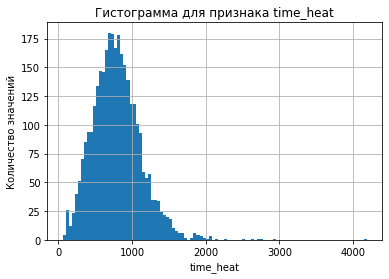

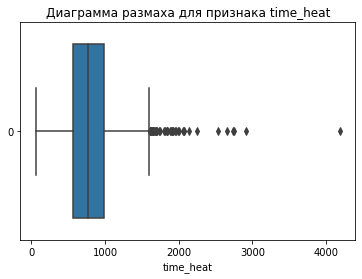

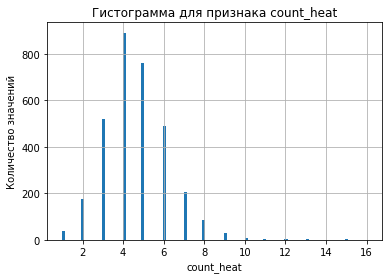

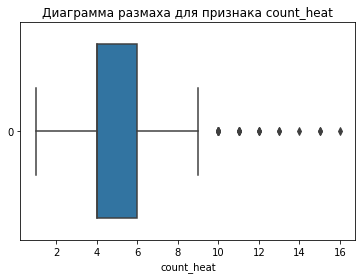

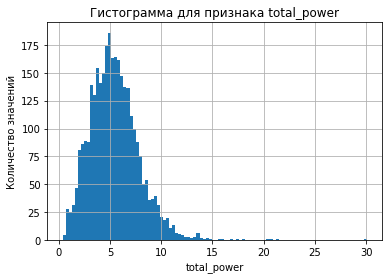

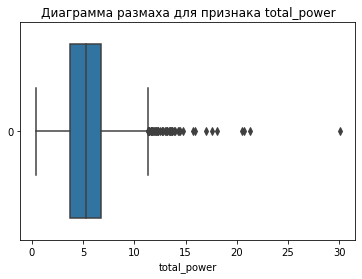

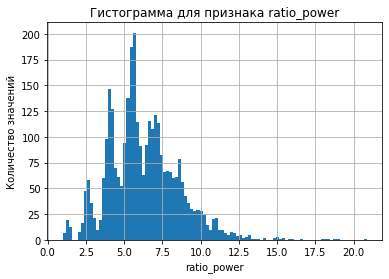

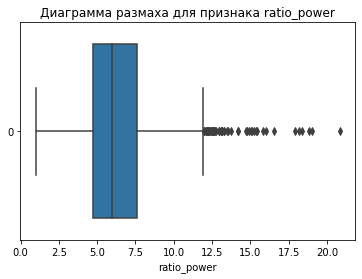

In [24]:
plot_func(data_arc)

- *Распределение время нагрева, распределение количества запусков нагрева, распределение общей мощности, распределение соотношения активной и реактивной мощности похожи на распределение Гаусса с хвостом в правой части.*

- *Чаще всего время нагрева находится между 700-600 секундами, количество запусков нагрева равняется 4, общая мощность равняется 5, соотношение активной мощности к реактивной равняется 6.*

- *Имеются выбросы в столбцах*

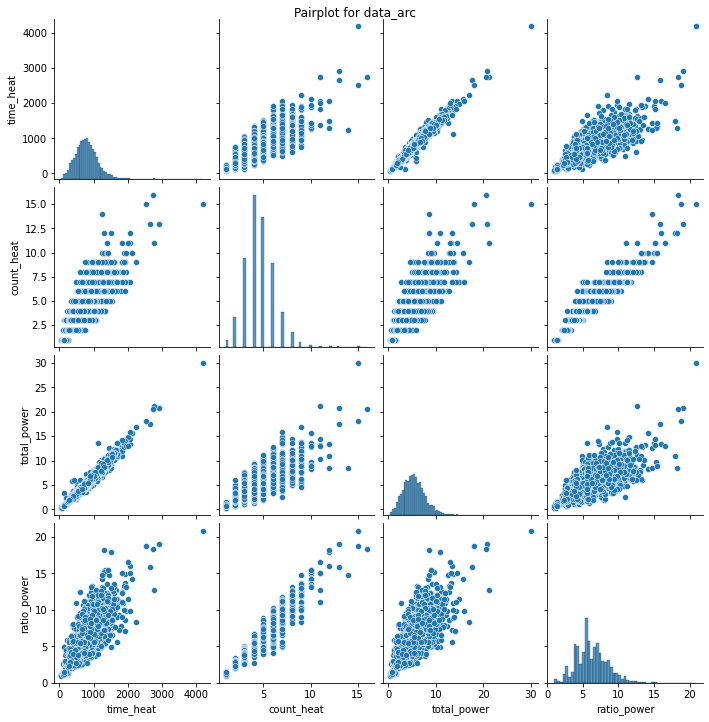

In [25]:
pairplt = sns.pairplot(data_arc.drop('key', axis=1));
pairplt.fig.suptitle('Pairplot for data_arc', y=1);

- *Чем больше время нагрева, тем выше количество запусков нагрева, выше общая мощность и выше соотношение активной и реактивиной мощности. Зависимость этих параметров от времени нагрева напоминает линейную.*

- *Чем больше запусков нагрева, тем выше общая мощность и отношение активной мощности к реактивной. Зависимость этих параметров от количества запусков нагрева напоминает линейную.*

- *Чем выше общая мощность, тем выше отношение активной мощности к реактивной. Зависимость этих параметров от общей мощности напоминает линейную.*

In [26]:
#Функция дя поиска экстремальных выбросы методом интерквартильных расстояний, 
#межквартильный размах берем равный 3 (только для экстремальных данных). 

def calc_upper_and_lower_limit_func(data):
    quantile_25 = data.quantile(.25)
    quantile_75 = data.quantile(.75)
    MKR = quantile_75 - quantile_25
    lower_limit = quantile_75 - 3 * MKR
    upper_limit = quantile_75 + 3 * MKR
    return lower_limit, upper_limit

In [27]:
def drop_blowout_func(data):
    print('Размер изначального датасета:')
    display(data.shape)
    for c in data.columns:
        lower_limit, upper_limit = calc_upper_and_lower_limit_func(data[c])
        data = data.loc[(data[c] >= lower_limit) & (data[c] <= upper_limit) | (data[c].isna() == True), :]
        print('Удаляем выбросы в', c)
        print('Размер полученного датасета:')
        display(data.shape)
    return data

Посмотрим на окончательный датасет.

In [28]:
info_func(data_arc, False)

,key,time_heat,count_heat,total_power,ratio_power
0,1,1098,5,8.061388,7.694490
1,2,811,4,5.050710,6.207336
2,3,655,5,4.124958,7.915599
3,4,741,4,5.269548,6.253946
4,5,869,4,5.599815,5.921711





<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3213 non-null   int64  
 1   time_heat    3213 non-null   int64  
 2   count_heat   3213 non-null   int64  
 3   total_power  3213 non-null   float64
 4   ratio_power  3213 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 279.6 KB


None

,key,time_heat,count_heat,total_power,ratio_power
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,1622.907874,793.063803,4.628696,5.421408,6.298042
std,934.844882,332.010795,1.608860,2.426174,2.305925
min,1.000000,57.000000,1.000000,0.361557,0.980955
25%,817.000000,569.000000,4.000000,3.752667,4.722370
50%,1623.000000,768.000000,4.000000,5.243475,5.955506
75%,2432.000000,982.000000,6.000000,6.785832,7.604818
max,3241.000000,4189.000000,16.000000,30.084487,20.859889


**Вывод:**

**Датасет после обработки имеет 3213 строк и 4 признака (время нагрева, количество запусков нагрева, общая мощность, соотношение активной и реактивной мощности). Датасет был сгруппирован по номеру партии. В датасете не обнаружено пропущенных значения и дубликатов. В датасете были найдены выбросы, а таккже аномальные значения в столбцах total_power, ratio_power (отрицательная мощность). В столбце time_heat был изменен тип данных на целочисленный.**

**Были проведен анализ данных по построенным графикам:**

- **Распределение время нагрева, распределение количества запусков нагрева, распределение общей мощности, распределение соотношения активной и реактивной мощности похожи на распределение Гаусса с хвостом в правой части.**
- **Чаще всего время нагрева находится между 700-600 секундами, количество запусков нагрева равняется 4, общая мощность равняется 5, соотношение активной мощности к реактивной равняется 6**
- **Чем больше время нагрева, тем выше количество запусков нагрева, выше общая мощность и выше соотношение активной и реактивиной мощности. Зависимость этих параметров от времени нагрева напоминает линейную.**
- **Чем больше запусков нагрева, тем выше общая мощность и отношение активной мощности к реактивной. Зависимость этих параметров от количества запусков нагрева напоминает линейную.**
- **Чем выше общая мощность, тем выше отношение активной мощности к реактивной. Зависимость этих параметров от общей мощности напоминает линейную.**

## Данные об объёме и времени подачи сыпучих материалов (steel.data_bulk, steel.data_bulk_time)

Выгрузим данные таблицы steel.data_bulk.

In [29]:
query = '''
SELECT key,
       "Bulk 1"  AS bulk_1,
       "Bulk 2"  AS bulk_2,
       "Bulk 3"  AS bulk_3,
       "Bulk 4"  AS bulk_4,
       "Bulk 5"  AS bulk_5,
       "Bulk 6"  AS bulk_6,
       "Bulk 7"  AS bulk_7,
       "Bulk 8"  AS bulk_8,
       "Bulk 9"  AS bulk_9,
       "Bulk 10"  AS bulk_10,
       "Bulk 11"  AS bulk_11,
       "Bulk 12"  AS bulk_12,
       "Bulk 13"  AS bulk_13,
       "Bulk 14"  AS bulk_14,
       "Bulk 15"  AS bulk_15
FROM steel.data_bulk
'''

data_bulk = pd.read_sql_query(query, con=engine)

Изучим данные.

In [30]:
info_func(data_bulk)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000





Количество дубликатов 0


*Датасет имеет 3129 строк и 16 столбцов (номер партии, объем сыпучего материала). В датасете отсутствуют дубликаты и аномальные значения. В датасете присутствуют пропущенные значения (когда материал не добавляли). В столбцах необходимо поменять типы данных на целочисленные.*

Посмотрим на количество данных в столбцах.

In [31]:
def find_bad_features(data):
    data_with_bad_features = (data.drop('key', axis=1).count() / data['key'].count() * 100).sort_values(ascending = False)
    data_with_bad_features.plot(kind='bar');
    plt.title('Количество данных в столбцах');
    plt.xlabel('Название столбца');
    plt.ylabel('Количество данных')
    plt.grid(True);
    plt.show();

    print(data_with_bad_features)
    return data_with_bad_features

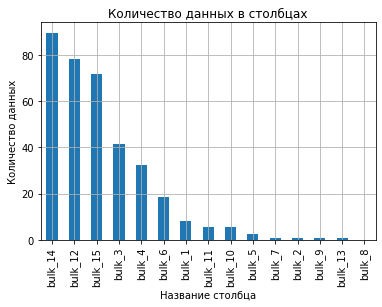

bulk_14    89.677213
bulk_12    78.299776
bulk_15    71.844040
bulk_3     41.482902
bulk_4     32.406520
bulk_6     18.408437
bulk_1      8.053691
bulk_11     5.656759
bulk_10     5.624800
bulk_5      2.460850
bulk_7      0.798977
bulk_2      0.703100
bulk_9      0.607223
bulk_13     0.575264
bulk_8      0.031959
dtype: float64


In [32]:
data_bulk_with_bad_features = find_bad_features(data_bulk)

Удалим малоинформативные столбцы bulk_5, bulk_7, bulk_2, bulk_9, bulk_13, bulk_8.

In [33]:
data_bulk = data_bulk.drop(data_bulk_with_bad_features.loc[(data_bulk_with_bad_features < 5)].index.tolist(), axis=1)

Построим гистограммы и диаграммы размаха и изучим распределения.

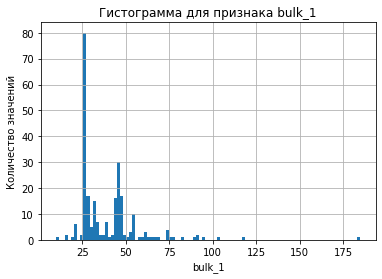

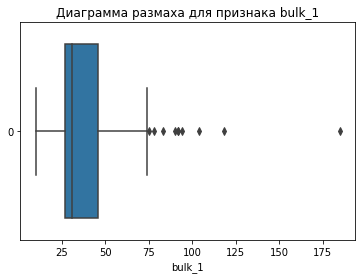

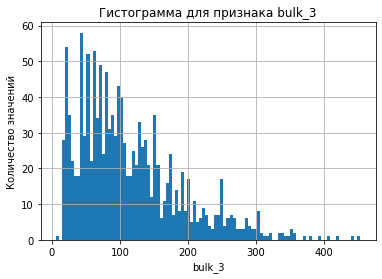

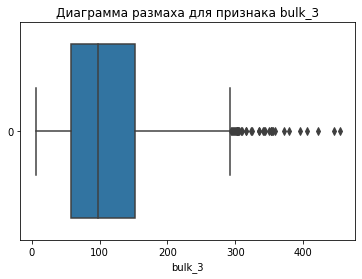

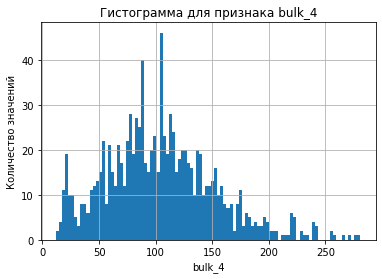

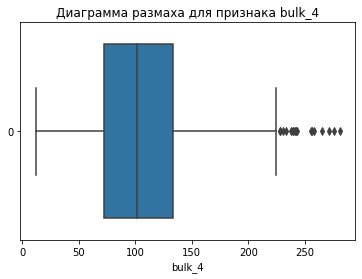

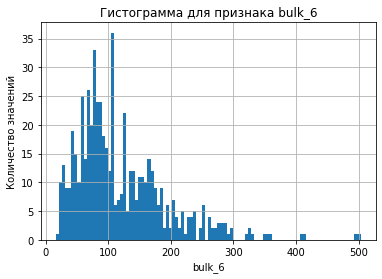

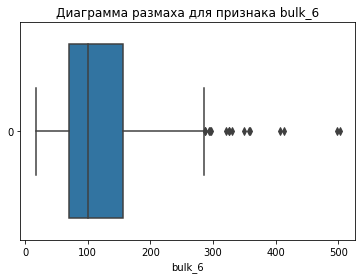

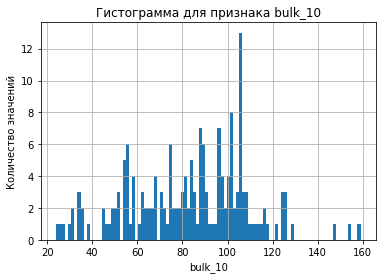

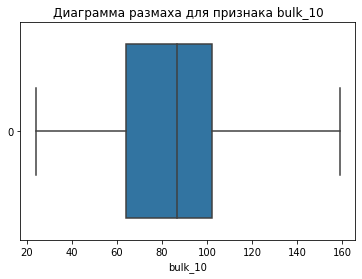

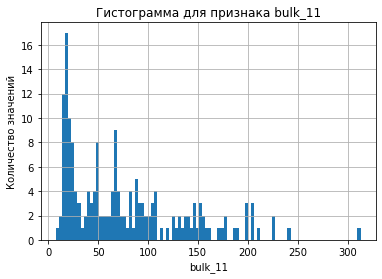

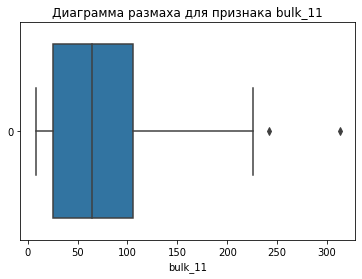

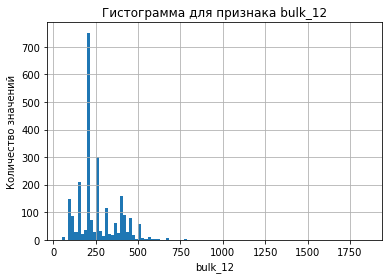

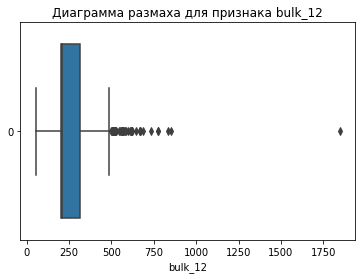

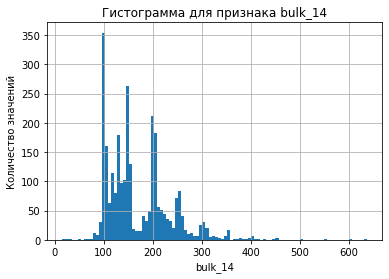

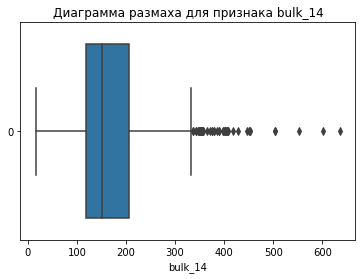

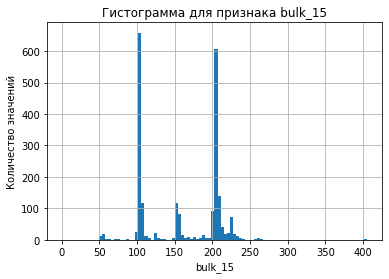

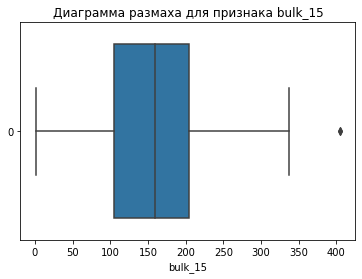

In [34]:
plot_func(data_bulk)

- *Для материалов bulk_1, bulk_11 чаще всего встречается значение 25.*

- *Для материала bulk_3 чаще всего встречается значение 50.*

- *Для материалов bulk_4, bulk_6, bulk_10 чаще всего встречается значение 100-105.*

- *Для материала bulk_12 чаще всего встречается значение 200.*

- *Для материалов bulk_14, bulk_15 чаще всего встречаются значения 100, 150, 200.*

- *Чаще всего использоваись материалы bulk_12, bulk_14, bulk_15, обычно их добавляли вместе*

- *Были найдены небольшие выбросы во всех столбцах.*

Проверим, есть ли партии, в которые не добавлялся сыпучий материал.

In [35]:
data_bulk.isna().all(axis=1).sum()

0

Таких партий нет.

Заполним пропуски на ноль, так как пропуск означает, что материал не добавляли в партию.

In [36]:
data_bulk = data_bulk.fillna(0)

Поменяем тип данных в столбцах на целочисленный.

In [37]:
def to_int_func(data):
    for c in data.columns:
        data[c] = data[c].astype('int')
    return data

In [38]:
data_bulk = to_int_func(data_bulk)

Посмотрим на окончательный датасет.

In [39]:
info_func(data_bulk)

,key,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
0,1,0,0,43,0,0,0,206,150,154
1,2,0,0,73,0,0,0,206,149,154
2,3,0,0,34,0,0,0,205,152,153
3,4,0,0,81,0,0,0,207,153,154
4,5,0,0,78,0,0,0,203,151,152





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   bulk_1   3129 non-null   int64
 2   bulk_3   3129 non-null   int64
 3   bulk_4   3129 non-null   int64
 4   bulk_6   3129 non-null   int64
 5   bulk_10  3129 non-null   int64
 6   bulk_11  3129 non-null   int64
 7   bulk_12  3129 non-null   int64
 8   bulk_14  3129 non-null   int64
 9   bulk_15  3129 non-null   int64
dtypes: int64(10)
memory usage: 244.6 KB


None

,key,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,47.240332,33.830617,21.892298,4.684564,4.345478,203.948226,152.706616,115.319271
std,933.337642,11.869164,74.239954,56.034505,55.492582,20.157323,22.699580,151.419639,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,148.000000,106.000000
75%,2431.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,263.000000,202.000000,204.000000
max,3241.000000,185.000000,454.000000,281.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000





Количество дубликатов 0


**Вывод:**

**Датасет имеет 3129 строк и 9 признаков (объем сыпучего материала). В датасете не были обнаружены дубликаты и аномальные значения. В датасете были найдены пропущенные значения и заменены на 0, так как пропуски означали то, что материал не добавляли. В датасете были найдены выбросы. В столбцах был изменен тип данных на целочисленный. Были удалены малоинформативные столбцы bulk_5, bulk_7, bulk_2, bulk_9, bulk_13, bulk_8.**

**Были проведен анализ данных по построенным графикам:**

- **Для материалов bulk_1, bulk_11 чаще всего встречается значение 25.**
- **Для материала bulk_3 чаще всего встречается значение 50.**
- **Для материалов bulk_4, bulk_6, bulk_10 чаще всего встречаются значения 100-105.**
- **Для материала bulk_12 чаще всего встречается значение 200.**
- **Для материалов bulk_14, bulk_15 чаще всего встречаются значения 100, 150, 200.**
- **Чаще всего использоваись материалы bulk_12, bulk_14, bulk_15, обычно их добавляли вместе**

Выгрузим данные таблицы steel.data_bulk_time, создав признаки для каждого материала - длительность нагрева первоначального материала с добавленным сыпучим материалом.

In [40]:
query = '''

WITH data_end_heat AS (
    SELECT key,
       MAX("EndHeat") AS end_heat
    FROM steel.data_arc
    GROUP BY key
)

SELECT dbt.key,
       CASE
           WHEN end_heat  > "Bulk 1" THEN EXTRACT(EPOCH FROM (end_heat - "Bulk 1")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Bulk 1")) - 86400
       END AS time_bulk_1,
       CASE
           WHEN end_heat  > "Bulk 3" THEN EXTRACT(EPOCH FROM (end_heat - "Bulk 3")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Bulk 3")) - 86400
       END AS time_bulk_3,
       CASE
           WHEN end_heat  > "Bulk 4" THEN EXTRACT(EPOCH FROM (end_heat - "Bulk 4")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Bulk 4")) - 86400
       END AS time_bulk_4,
       CASE
           WHEN end_heat  > "Bulk 6" THEN EXTRACT(EPOCH FROM (end_heat - "Bulk 6")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Bulk 6")) - 86400
       END AS time_bulk_6,
       CASE
           WHEN end_heat  > "Bulk 10" THEN EXTRACT(EPOCH FROM (end_heat - "Bulk 10")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Bulk 10")) - 86400
       END AS time_bulk_10,
       CASE
           WHEN end_heat  > "Bulk 11" THEN EXTRACT(EPOCH FROM (end_heat - "Bulk 11")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Bulk 11")) - 86400
       END AS time_bulk_11,
       CASE
           WHEN end_heat  > "Bulk 12" THEN EXTRACT(EPOCH FROM (end_heat - "Bulk 12")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Bulk 12")) - 86400
       END AS time_bulk_12,
       CASE
           WHEN end_heat  > "Bulk 14" THEN EXTRACT(EPOCH FROM (end_heat - "Bulk 14")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Bulk 14")) - 86400
       END AS time_bulk_14,
       CASE
           WHEN end_heat  > "Bulk 15" THEN EXTRACT(EPOCH FROM (end_heat - "Bulk 15")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Bulk 15")) - 86400
       END AS time_bulk_15
       
FROM steel.data_bulk_time AS dbt
JOIN data_end_heat AS deh ON dbt.key=deh.key
'''

data_bulk_time = pd.read_sql_query(query, con=engine)

Изучим данные.

In [41]:
info_func(data_bulk_time)

,key,time_bulk_1,time_bulk_3,time_bulk_4,time_bulk_6,time_bulk_10,time_bulk_11,time_bulk_12,time_bulk_14,time_bulk_15
0,1,NaN,NaN,427.0,NaN,NaN,NaN,1485.0,1485.0,1485.0
1,2,NaN,NaN,400.0,NaN,NaN,NaN,778.0,778.0,778.0
2,3,NaN,NaN,73.0,NaN,NaN,NaN,1359.0,1359.0,1359.0
3,4,NaN,NaN,547.0,NaN,NaN,NaN,986.0,986.0,986.0
4,5,NaN,NaN,905.0,NaN,NaN,NaN,1259.0,1259.0,1259.0





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128 entries, 0 to 3127
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3128 non-null   int64  
 1   time_bulk_1   252 non-null    float64
 2   time_bulk_3   1298 non-null   float64
 3   time_bulk_4   1014 non-null   float64
 4   time_bulk_6   575 non-null    float64
 5   time_bulk_10  176 non-null    float64
 6   time_bulk_11  177 non-null    float64
 7   time_bulk_12  2450 non-null   float64
 8   time_bulk_14  2806 non-null   float64
 9   time_bulk_15  2248 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 244.5 KB


None

,key,time_bulk_1,time_bulk_3,time_bulk_4,time_bulk_6,time_bulk_10,time_bulk_11,time_bulk_12,time_bulk_14,time_bulk_15
count,3128.000000,252.000000,1298.000000,1014.000000,575.000000,176.000000,177.000000,2450.000000,2806.000000,2248.000000
mean,1624.813619,2171.547619,1626.593220,1718.474359,1933.737391,968.369318,63.090395,1878.120408,1782.273699,1859.488879
std,933.176672,5809.203426,13367.361089,14786.550970,13614.717669,11454.579044,13716.722924,5692.940053,5146.597789,5377.405219
min,1.000000,11.000000,-78962.000000,-83880.000000,-81769.000000,-55478.000000,-73945.000000,11.000000,11.000000,53.000000
25%,816.750000,976.750000,461.000000,466.500000,506.500000,505.000000,402.000000,939.000000,929.250000,963.750000
50%,1623.000000,1293.000000,780.000000,757.500000,870.000000,745.500000,765.000000,1293.000000,1282.000000,1310.000000
75%,2431.250000,1942.000000,1115.750000,1125.750000,1337.000000,1047.000000,1147.000000,1875.000000,1847.000000,1896.000000
max,3241.000000,86155.000000,86294.000000,86338.000000,86282.000000,86256.000000,85761.000000,86129.000000,86185.000000,86129.000000





Количество дубликатов 0


*Датасет имеет 3128 строк и 10 столбцов (номер партии, длительность нагрева первоначального материала с добавленным сыпучим материалом). В датасете отсутствуют дубликаты. В датасете присутствуют пропущенные значения (материал не добавляли), аномальные значения (отрицательное время и время, превышающее время нагрева самой длительной операции в таблице data_arc). В столбцах необходимо поменять типы данных на целочисленные.*

Удалим аномальные значения в столбцах (отрицательное время и время, превышающее время нагрева самой длительной операции в таблице data_arc).

In [42]:
max_time = data_arc['time_heat'].max()
def drop_anomalies_func(data, max_time=max_time):
    for c in data.drop('key', axis=1).columns:
        data = data.loc[((data[c] >= 0) & (data[c] <= max_time)) | (data[c].isna() == True), :]
    display(data.shape)
    return data

In [43]:
data_bulk_time = drop_anomalies_func(data_bulk_time)

(2895, 10)

Такое большое количество аномальных данных может быть вызвано асинхронностью датчиковой аппаратуры.

Построим гистограммы и диаграммы размаха и изучим распределения.

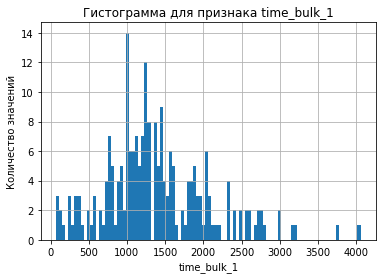

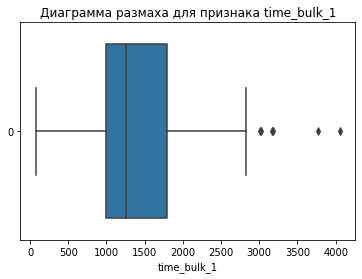

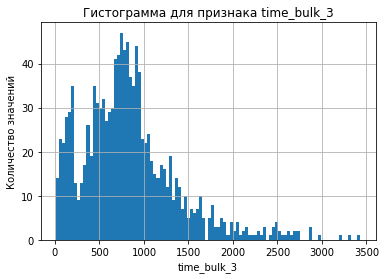

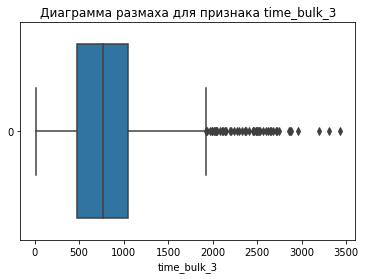

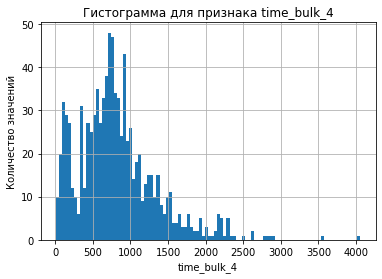

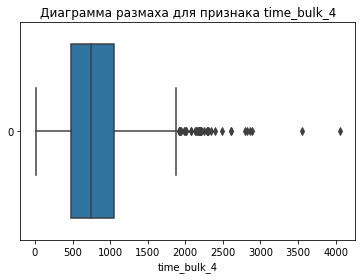

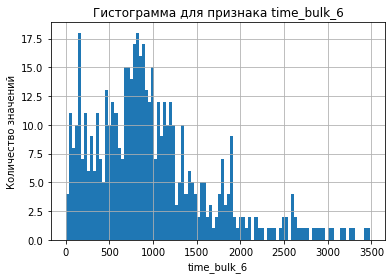

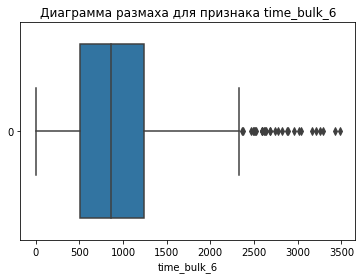

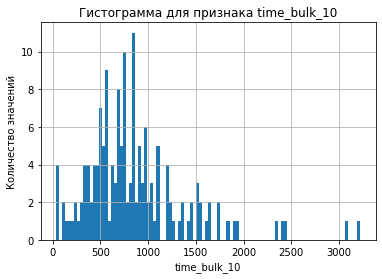

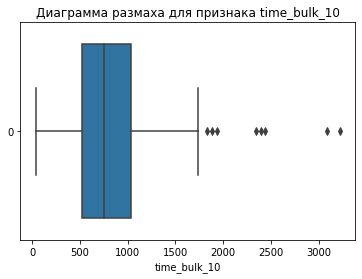

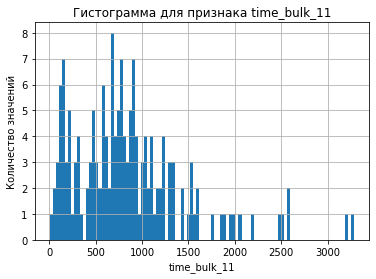

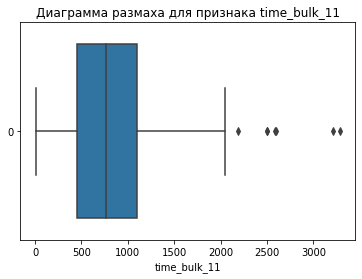

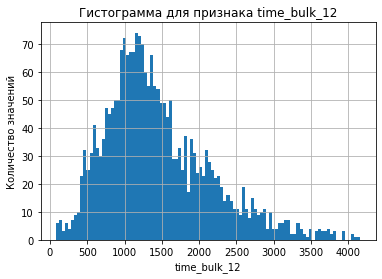

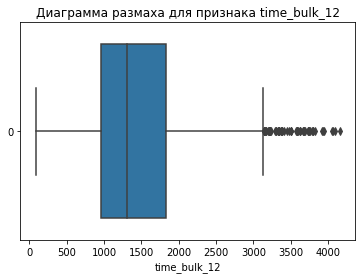

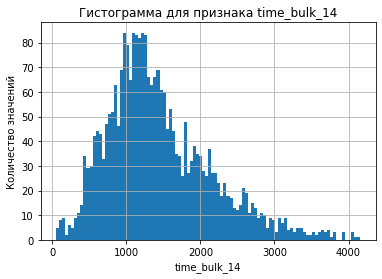

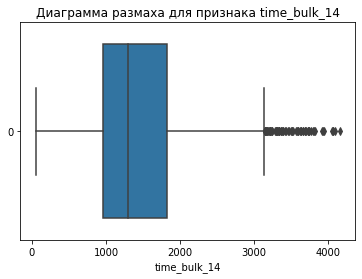

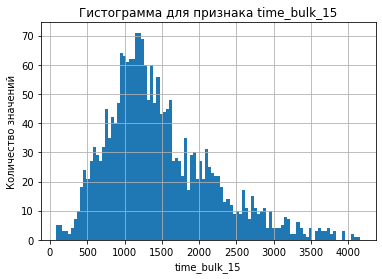

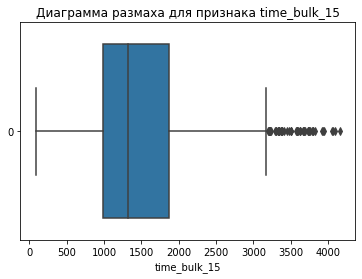

In [44]:
plot_func(data_bulk_time)

- *Для материала bulk_11 чаще всего встречаются значения 600-700.*

- *Для материалов bulk_3, bulk_4, bulk_6, bulk_10 чаще всего встречается значение 700-800.*

- *Для материалов bulk_1, bulk_12, bulk_14, bulk_15 чаще всего встречается значение 1000-1200.*

- *Были найдены небольшие выбросы во всех столбцах.*

Заполним пропуски на ноль, так как пропуск означает, что материал не добавляли в партию, а значит и длительность нагрева основного материала совместно с сыпучим будет нулевая.

In [45]:
data_bulk_time = data_bulk_time.fillna(0)

Поменяем тип данных в столбцах на целочисленный.

In [46]:
data_bulk_time = to_int_func(data_bulk_time)

Посмотрим на окончательный датасет, построим графики и исследуем данные.

In [47]:
info_func(data_bulk_time)

,key,time_bulk_1,time_bulk_3,time_bulk_4,time_bulk_6,time_bulk_10,time_bulk_11,time_bulk_12,time_bulk_14,time_bulk_15
0,1,0,0,427,0,0,0,1485,1485,1485
1,2,0,0,400,0,0,0,778,778,778
2,3,0,0,73,0,0,0,1359,1359,1359
3,4,0,0,547,0,0,0,986,986,986
4,5,0,0,905,0,0,0,1259,1259,1259





<class 'pandas.core.frame.DataFrame'>
Int64Index: 2895 entries, 0 to 3127
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   key           2895 non-null   int64
 1   time_bulk_1   2895 non-null   int64
 2   time_bulk_3   2895 non-null   int64
 3   time_bulk_4   2895 non-null   int64
 4   time_bulk_6   2895 non-null   int64
 5   time_bulk_10  2895 non-null   int64
 6   time_bulk_11  2895 non-null   int64
 7   time_bulk_12  2895 non-null   int64
 8   time_bulk_14  2895 non-null   int64
 9   time_bulk_15  2895 non-null   int64
dtypes: int64(10)
memory usage: 313.3 KB


None

,key,time_bulk_1,time_bulk_3,time_bulk_4,time_bulk_6,time_bulk_10,time_bulk_11,time_bulk_12,time_bulk_14,time_bulk_15
count,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000
mean,1621.505699,104.396200,340.153713,259.219689,176.807945,46.450432,47.070466,1151.769257,1309.531261,1072.344732
std,937.257795,410.608845,534.436469,482.113819,471.930587,228.830427,240.418810,858.397353,787.666993,890.619838
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,808.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,539.000000,821.000000,0.000000
50%,1611.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1129.000000,1230.000000,1074.000000
75%,2438.500000,0.000000,661.500000,421.000000,0.000000,0.000000,0.000000,1636.000000,1758.000000,1593.500000
max,3241.000000,4058.000000,3433.000000,4058.000000,3485.000000,3224.000000,3287.000000,4160.000000,4160.000000,4160.000000





Количество дубликатов 0


**Вывод:**

**Датасет содержит после обработки 2895 строк и 9 признаков (длительность нагрева первоначального материала с добавленным сыпучим материалом). В датасете не были обнаружены дубликаты. В датасете были найдены пропущенные значения и заменены на 0, так как пропуски означали то, что материал не добавляли. В датасете были исследованы выбросы. В датасете были найдены и удалены аномалии (отрицательное время и время, превышающее время нагрева самой длительной операции в таблице data_arc). В столбцах был изменен тип данных на целочисленный.**

**Были проведен анализ данных по построенным графикам:**

- **Для материала bulk_11 чаще всего встречаются значения 600-700.**
- **Для материалов bulk_3, bulk_4, bulk_6, bulk_10 чаще всего встречается значение 700-800.**
- **Для материалов bulk_1, bulk_12, bulk_14, bulk_15 чаще всего встречается значение 1000-1200.**

## Данные об объёме и времени подачи проволочных материалов (steel.data_wire, steel.data_wire_time)

Выгрузим данные таблицы steel.data_wire.


In [48]:
query = '''
SELECT key,
       "Wire 1"  AS wire_1,
       "Wire 2"  AS wire_2,
       "Wire 3"  AS wire_3,
       "Wire 4"  AS wire_4,
       "Wire 5"  AS wire_5,
       "Wire 6"  AS wire_6,
       "Wire 7"  AS wire_7,
       "Wire 8"  AS wire_8,
       "Wire 9"  AS wire_9
FROM steel.data_wire
'''

data_wire = pd.read_sql_query(query, con=engine)

Изучим данные.

In [49]:
info_func(data_wire)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604





Количество дубликатов 0


*Датасет имеет 3081 строк и 10 столбцов (номер партии, объем провочного материала). В датасете отсутствуют дубликаты и аномальные значения. В датасете присутствуют пропущенные значения (материал не добавляли). В столбцах необходимо поменять типы данных на целочисленные.*


Посмотрим на количество данных в столбцах.

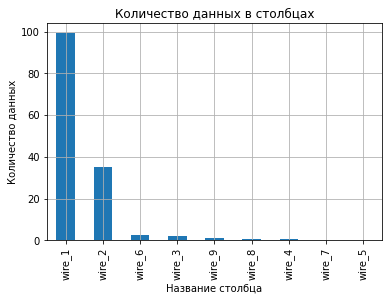

wire_1    99.156118
wire_2    35.021097
wire_6     2.369361
wire_3     2.044791
wire_9     0.941253
wire_8     0.616683
wire_4     0.454398
wire_7     0.357027
wire_5     0.032457
dtype: float64


In [50]:
data_wire_with_bad_features = find_bad_features(data_wire)

Удалим малоинформативные столбцы wire_6, wire_3, wire_9, wire_8, wire_4, wire_7, wire_5.

In [51]:
data_wire = data_wire.drop(data_wire_with_bad_features.loc[(data_wire_with_bad_features < 5)].index.tolist(), axis=1)

Построим гистограммы и диаграммы размаха и изучим распределения.

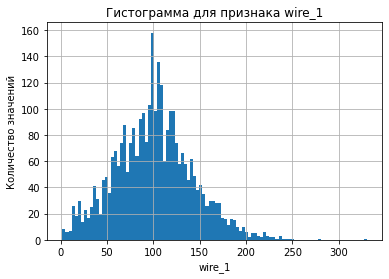

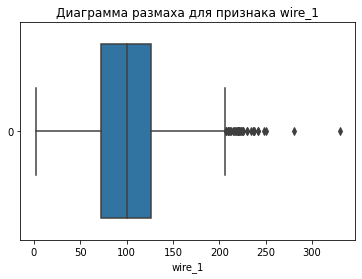

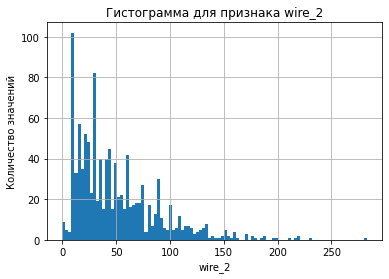

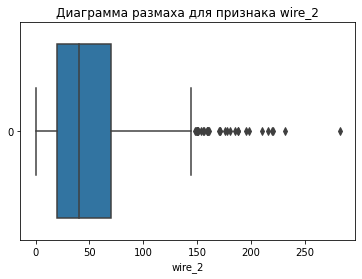

In [52]:
plot_func(data_wire)

- *Для материала wire_1 чаще всего встречается значение 100.*

- *Для материала wire_2 чаще всего встречается значение 10.*

- *Чаще всего использовался материал wire_1.* 

- *Имеются выбросы в некоторых столбцах.* 

Проверим, во все ли партии добавлялся проволочный материал.

In [53]:
data_wire.isna().all(axis=1).sum()

0

Таких партий нет.


Заполним пропуски на ноль, так как пропуск означает, что материал не добавляли в партию.

In [54]:
data_wire = data_wire.fillna(0)

Поменяем тип данных в столбцах на целочисленный.

In [55]:
data_wire = to_int_func(data_wire)

Посмотрим на окончательный датасет.

In [56]:
info_func(data_wire)

,key,wire_1,wire_2
0,1,60,0
1,2,96,0
2,3,91,0
3,4,89,0
4,5,89,9





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   key     3081 non-null   int64
 1   wire_1  3081 non-null   int64
 2   wire_2  3081 non-null   int64
dtypes: int64(3)
memory usage: 72.3 KB


None

,key,wire_1,wire_2
count,3081.000000,3081.000000,3081.000000
mean,1623.426485,99.826355,17.637131
std,932.996726,42.805617,33.420590
min,1.000000,0.000000,0.000000
25%,823.000000,70.000000,0.000000
50%,1619.000000,100.000000,0.000000
75%,2434.000000,125.000000,23.000000
max,3241.000000,330.000000,282.000000





Количество дубликатов 0


**Вывод:**

**Датасет имеет 3081 строк и 2 признака (объем провочного материала). В датасете не были обнаружены дубликаты и аномальные значения. В датасете были найдены пропущенные значения и заменены на 0, так как пропуски означали то, что материал не добавляли. В датасете были найдены выбросы. В столбцах был изменен тип данных на целочисленный. Были удалены малоинформативные столбцы wire_6, wire_3, wire_9, wire_8, wire_4, wire_7, wire_5.**

**Были проведен анализ данных по построенным графикам:**

- **Для материала wire_1 чаще всего встречается значение 100.**
- **Для материала wire_2 чаще всего встречается значение 10.**
- **Чаще всего использовался материал wire_1.**

Выгрузим данные таблицы steel.data_wire_time, создав признаки для каждого материала - длительность нагрева первоначального материала с добавленным проволочным материалом.


In [57]:
query = '''

WITH data_end_heat AS (
    SELECT key,
       MAX("EndHeat") AS end_heat
    FROM steel.data_arc
    GROUP BY key
)

SELECT dwt.key,
       CASE
           WHEN end_heat  > "Wire 1" THEN EXTRACT(EPOCH FROM (end_heat - "Wire 1")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Wire 1")) - 86400
       END AS time_wire_1,
       CASE
           WHEN end_heat  > "Wire 2" THEN EXTRACT(EPOCH FROM (end_heat - "Wire 2")) 
           ELSE EXTRACT(EPOCH FROM (end_heat)) + EXTRACT(EPOCH FROM ("Wire 2")) - 86400
       END AS time_wire_2
FROM steel.data_wire_time AS dwt
JOIN data_end_heat AS deh ON dwt.key=deh.key
'''

data_wire_time = pd.read_sql_query(query, con=engine)

Изучим данные.

In [58]:
info_func(data_wire_time)

,key,time_wire_1,time_wire_2
0,1,1016.0,NaN
1,2,428.0,NaN
2,3,1112.0,NaN
3,4,585.0,NaN
4,5,940.0,109.0





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3080 non-null   int64  
 1   time_wire_1  3054 non-null   float64
 2   time_wire_2  1079 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


None

,key,time_wire_1,time_wire_2
count,3080.000000,3054.000000,1079.000000
mean,1623.862987,1687.098559,1431.404078
std,932.833522,13070.562286,15045.869103
min,1.000000,-84651.000000,-81006.000000
25%,823.750000,625.000000,444.000000
50%,1619.500000,938.000000,784.000000
75%,2434.250000,1389.750000,1157.500000
max,3241.000000,86330.000000,86232.000000





Количество дубликатов 0


*Датасет имеет 3080 строк и 3 столбца (номер партии, длительность нагрева первоначального материала с добавленным проволочным материалом). В датасете отсутствуют дубликаты. В датасете присутствуют пропущенные значения (материал не добавляли), аномальные значения (отрицательное время и время, превышающее время нагрева самой длительной операции в таблице data_arc). В столбцах необходимо поменять типы данных на целочисленные.*


Удалим аномальные значения в столбцах (отрицательное время и время, превышающее время нагрева самой длительной операции в таблице data_arc).

In [59]:
data_wire_time = drop_anomalies_func(data_wire_time)

(2871, 3)

Такое большое количество аномальных данных может быть вызвано асинхронностью датчиковой аппаратуры.


Построим гистограммы и диаграммы размаха и изучим рапсределения.

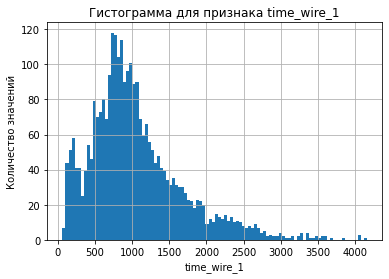

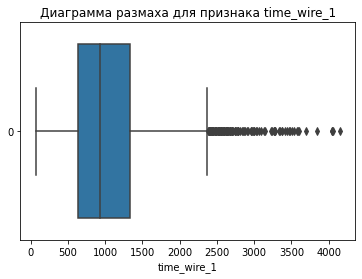

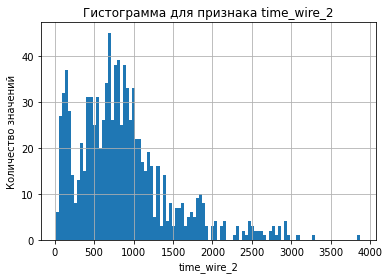

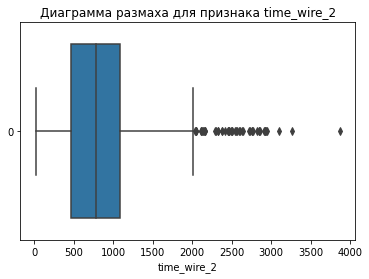

In [60]:
plot_func(data_wire_time)

- *Для материалов wire_1, wire_2 чаще всего встречаются значения 700-750.*

- *Были найдены небольшие выбросы в нескольких столбцах.*

Заполним пропуски на ноль, так как пропуск означает, что материал не добавляли в партию, а значит и длительность нагрева основного материала совместно с проволочным будет нулевая.


In [61]:
data_wire_time = data_wire_time.fillna(0)

Поменяем тип данных в столбцах на целочисленный.

In [62]:
data_wire_time = to_int_func(data_wire_time)

Посмотрим на окончательный датасет.

In [63]:
info_func(data_wire_time)

,key,time_wire_1,time_wire_2
0,1,1016,0
1,2,428,0
2,3,1112,0
3,4,585,0
4,5,940,109





<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   key          2871 non-null   int64
 1   time_wire_1  2871 non-null   int64
 2   time_wire_2  2871 non-null   int64
dtypes: int64(3)
memory usage: 154.3 KB


None

,key,time_wire_1,time_wire_2
count,2871.000000,2871.000000,2871.000000
mean,1620.665970,1043.431209,297.150470
std,936.512668,628.519235,536.569041
min,1.000000,0.000000,0.000000
25%,815.500000,629.000000,0.000000
50%,1610.000000,924.000000,0.000000
75%,2442.500000,1330.000000,488.000000
max,3241.000000,4154.000000,3873.000000





Количество дубликатов 0


**Вывод:**

**Датасет содержит после обработки 2871 строк и 2 признака (длительность нагрева первоначального материала с добавленным проволочным материалом). В датасете не были обнаружены дубликаты. В датасете были найдены пропущенные значения и заменены на 0, так как пропуски означали то, что материал не добавляли. В датасете были исследованы выбросы. В датасете были найдены и удалены аномалии (отрицательное время и время, превышающее время нагрева самой длительной операции в таблице data_arc). В столбцах был изменен тип данных на целочисленный.**

**Были проведен анализ данных по построенным графикам:**

**Для материалов wire_1, wire_2 чаще всего встречаются значения 700-750.**


## Данные о продувке сплава газом (steel.data_gas)

Выгрузим данные таблицы steel.data_gas.

In [64]:
query = '''

SELECT *
FROM steel.data_gas
'''

data_gas = pd.read_sql_query(query, con=engine)

Изучим данные.

In [65]:
info_func(data_gas)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040





Количество дубликатов 0


В датасете 3239 строк и 2 столбца (номер партии и объем газа). В датасете нет пропусков, дубликатов и аномалий.

Построим гистограмму и диаграмму размаха, чтобы изучить данные и посмотреть распределения.

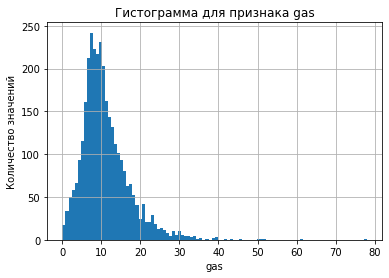

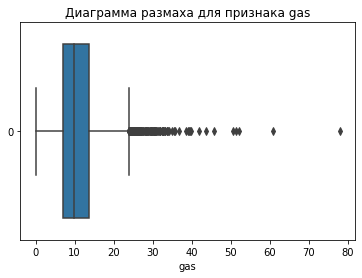

In [66]:
plot_func(data_gas)

- *Распределение похоже на распределение Гаусса с хвостом в правой части, наиболее частое значение объема газа около 8.*

- *Выбросы имеются.*

**Вывод:**

**В датасете 3229 строка и 2 столбца (номер партии и объем газа). В датасете нет пропусков, дубликатов и аномалий. В датасете были найдены выбросы.**

**Были построены графики и изучены: распределение похоже на распределение Гаусса с хвостом в правой части, наиболее частое значение объема газа около 8.**

## Данные об измерениях температуры (steel.data_temp)

Выгрузим данные таблицы steel.data_temp, создав следующие признаки: начальная температура партии, последняя температура партии. Будем рассматривать только партии, где нет пропущенных значений температуры, производилось не менее двух измерений, температура в партии не менее 1500.

In [67]:
query = '''

SELECT key,
       measure_temp_first,
       measure_temp_last
FROM
(
    SELECT DISTINCT key,
           FIRST_VALUE("MesaureTime") OVER (PARTITION BY key) AS measure_time_first,
           FIRST_VALUE("Temperature") OVER (PARTITION BY key) AS measure_temp_first,
           LAST_VALUE("MesaureTime") OVER (PARTITION BY key) AS measure_time_last,
           LAST_VALUE("Temperature") OVER (PARTITION BY key) AS measure_temp_last
    FROM steel.data_temp
    WHERE "Temperature" IS NOT NULL
          AND key IN 
          (
          SELECT key
          FROM steel.data_temp
          GROUP BY key
          HAVING MIN("Temperature") >= 1500
          )
    ORDER BY key
) AS data_temp_first_last
WHERE measure_time_first != measure_time_last
'''

data_temp = pd.read_sql_query(query, con=engine)

Изучим данные.

In [68]:
info_func(data_temp)

,key,measure_temp_first,measure_temp_last
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2470 non-null   int64  
 1   measure_temp_first  2470 non-null   float64
 2   measure_temp_last   2470 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.0 KB


None

,key,measure_temp_first,measure_temp_last
count,2470.000000,2470.000000,2470.000000
mean,1250.254251,1588.997571,1595.309312
std,720.164704,24.997740,15.965989
min,1.000000,1519.000000,1541.000000
25%,628.250000,1572.000000,1587.000000
50%,1251.500000,1588.000000,1593.000000
75%,1872.750000,1605.000000,1599.000000
max,2499.000000,1679.000000,1700.000000





Количество дубликатов 0


Датасет имеет 2470 строк и 3 столбца (номер партии, начальная температура, последняя температура). В датасета при выгрузке данных из базы данных были удалены пропуски, аномальные значения (температура ниже 1500), партии, где было меньше двух измерений температуры. В датасете отсутствуют дубликаты. Необходимо поменять тип данных на целочисленный во всех столбцах.

Построим гистограммы и диаграммы размаха и изучим распределения полученного датасета.

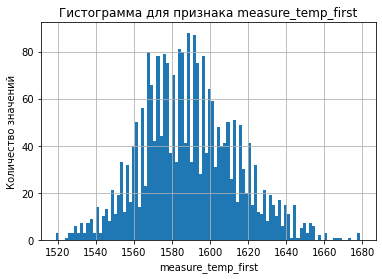

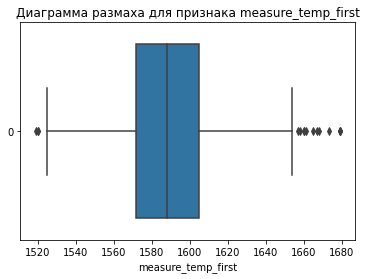

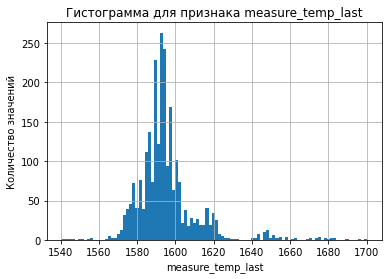

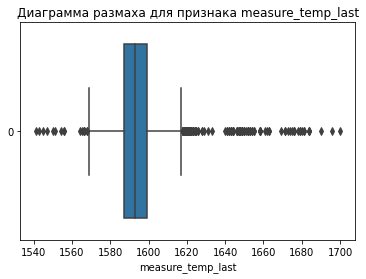

In [69]:
plot_func(data_temp)

- *Распределения напоминают распределение Гаусса. Наиболее частое значение первоначальной температуры и конечной температуры - 1590.*

- *Выбросы имеются.* 

Поменяем тип данных в столбцах на целочисленный.

In [70]:
data_temp = to_int_func(data_temp)

**Вывод:**

**Датасет имеет 2470 строк и 2 признака (начальная температура, последняя температура). В датасета при выгрузке данных из базы данных были удалены пропуски, аномальные значения (температура ниже 1500), партии, где было меньше двух измерений температуры. В датасете отсутствуют дубликаты. Был изменен тип данных столбцов на целочисленный.**

**Были построены и изучены графики: распределения напоминают распределение Гаусса, наиболее частое значение первоначальной температуры и конечной температуры - 1590.**

## Объединение таблиц

Объединим таблицы data_arc, data_bulk, data_wire, data_gas, data_temp, data_bulk_time, data_wire_time по ключу - номер партии.

In [71]:
data = data_arc
for d in [data_bulk, data_wire, data_gas, data_temp, data_bulk_time, data_wire_time]:
    data = data.merge(d, on='key', how='inner')
data = data.drop('key', axis=1)

Посмотрим на полученный датасет.

In [72]:
info_func(data, False)

,time_heat,count_heat,total_power,ratio_power,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas,measure_temp_first,measure_temp_last,time_bulk_1,time_bulk_3,time_bulk_4,time_bulk_6,time_bulk_10,time_bulk_11,time_bulk_12,time_bulk_14,time_bulk_15,time_wire_1,time_wire_2
0,1098,5,8.061388,7.694490,0,0,43,0,0,0,206,150,154,60,0,29.749986,1571,1613,0,0,427,0,0,0,1485,1485,1485,1016,0
1,811,4,5.050710,6.207336,0,0,73,0,0,0,206,149,154,96,0,12.555561,1581,1602,0,0,400,0,0,0,778,778,778,428,0
2,655,5,4.124958,7.915599,0,0,34,0,0,0,205,152,153,91,0,28.554793,1596,1599,0,0,73,0,0,0,1359,1359,1359,1112,0
3,741,4,5.269548,6.253946,0,0,81,0,0,0,207,153,154,89,0,18.841219,1601,1625,0,0,547,0,0,0,986,986,986,585,0
4,869,4,5.599815,5.921711,0,0,78,0,0,0,203,151,152,89,9,5.413692,1576,1602,0,0,905,0,0,0,1259,1259,1259,940,109





<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time_heat           2106 non-null   int64  
 1   count_heat          2106 non-null   int64  
 2   total_power         2106 non-null   float64
 3   ratio_power         2106 non-null   float64
 4   bulk_1              2106 non-null   int64  
 5   bulk_3              2106 non-null   int64  
 6   bulk_4              2106 non-null   int64  
 7   bulk_6              2106 non-null   int64  
 8   bulk_10             2106 non-null   int64  
 9   bulk_11             2106 non-null   int64  
 10  bulk_12             2106 non-null   int64  
 11  bulk_14             2106 non-null   int64  
 12  bulk_15             2106 non-null   int64  
 13  wire_1              2106 non-null   int64  
 14  wire_2              2106 non-null   int64  
 15  gas                 2106 non-null   float64
 16  mea

None

,time_heat,count_heat,total_power,ratio_power,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas,measure_temp_first,measure_temp_last,time_bulk_1,time_bulk_3,time_bulk_4,time_bulk_6,time_bulk_10,time_bulk_11,time_bulk_12,time_bulk_14,time_bulk_15,time_wire_1,time_wire_2
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000
mean,814.726496,4.755935,5.564831,6.493266,3.166192,47.330009,38.208452,21.902184,4.995252,4.225546,210.488604,154.740266,121.894587,102.392213,17.372270,11.241204,1585.827635,1593.555081,114.461538,349.435423,290.045584,184.406933,53.462013,47.239791,1198.552707,1352.805793,1128.456315,1078.063153,305.298196
std,296.290350,1.392643,2.167293,2.058024,11.438773,75.246987,59.671538,54.424547,20.876972,22.660752,151.208243,78.761454,83.747950,42.775457,33.149701,5.977830,23.030749,10.825897,427.547785,550.956737,500.259127,484.626780,250.102563,240.754509,886.520172,811.102791,910.727796,629.428576,549.300730
min,61.000000,1.000000,0.398733,1.005351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1550.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,611.000000,4.000000,4.008334,5.158588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106.000000,106.000000,0.000000,74.000000,0.000000,7.378166,1570.000000,1587.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,574.500000,865.000000,0.000000,667.000000,0.000000
50%,790.000000,5.000000,5.360412,6.215492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,149.000000,112.000000,101.000000,0.000000,10.087796,1585.000000,1593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1175.500000,1268.500000,1127.500000,958.500000,0.000000
75%,995.000000,6.000000,6.850343,7.758962,0.000000,80.000000,79.750000,0.000000,0.000000,0.000000,288.000000,204.000000,204.000000,127.000000,23.000000,14.049159,1601.000000,1598.000000,0.000000,671.750000,550.750000,0.000000,0.000000,0.000000,1717.000000,1827.000000,1665.750000,1380.750000,500.500000
max,2247.000000,12.000000,16.947191,17.930358,94.000000,454.000000,281.000000,407.000000,159.000000,313.000000,853.000000,428.000000,405.000000,330.000000,231.000000,60.935689,1660.000000,1647.000000,3774.000000,3433.000000,3551.000000,3485.000000,3224.000000,2595.000000,4160.000000,4160.000000,4160.000000,3840.000000,3268.000000


Датасет имеет 2106 строк и 29 признаков, включая целевой.

Построим матрицу корреляции для всех признаков.

interval columns not set, guessing: ['time_heat', 'count_heat', 'total_power', 'ratio_power', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'gas', 'measure_temp_first', 'measure_temp_last', 'time_bulk_1', 'time_bulk_3', 'time_bulk_4', 'time_bulk_6', 'time_bulk_10', 'time_bulk_11', 'time_bulk_12', 'time_bulk_14', 'time_bulk_15', 'time_wire_1', 'time_wire_2']


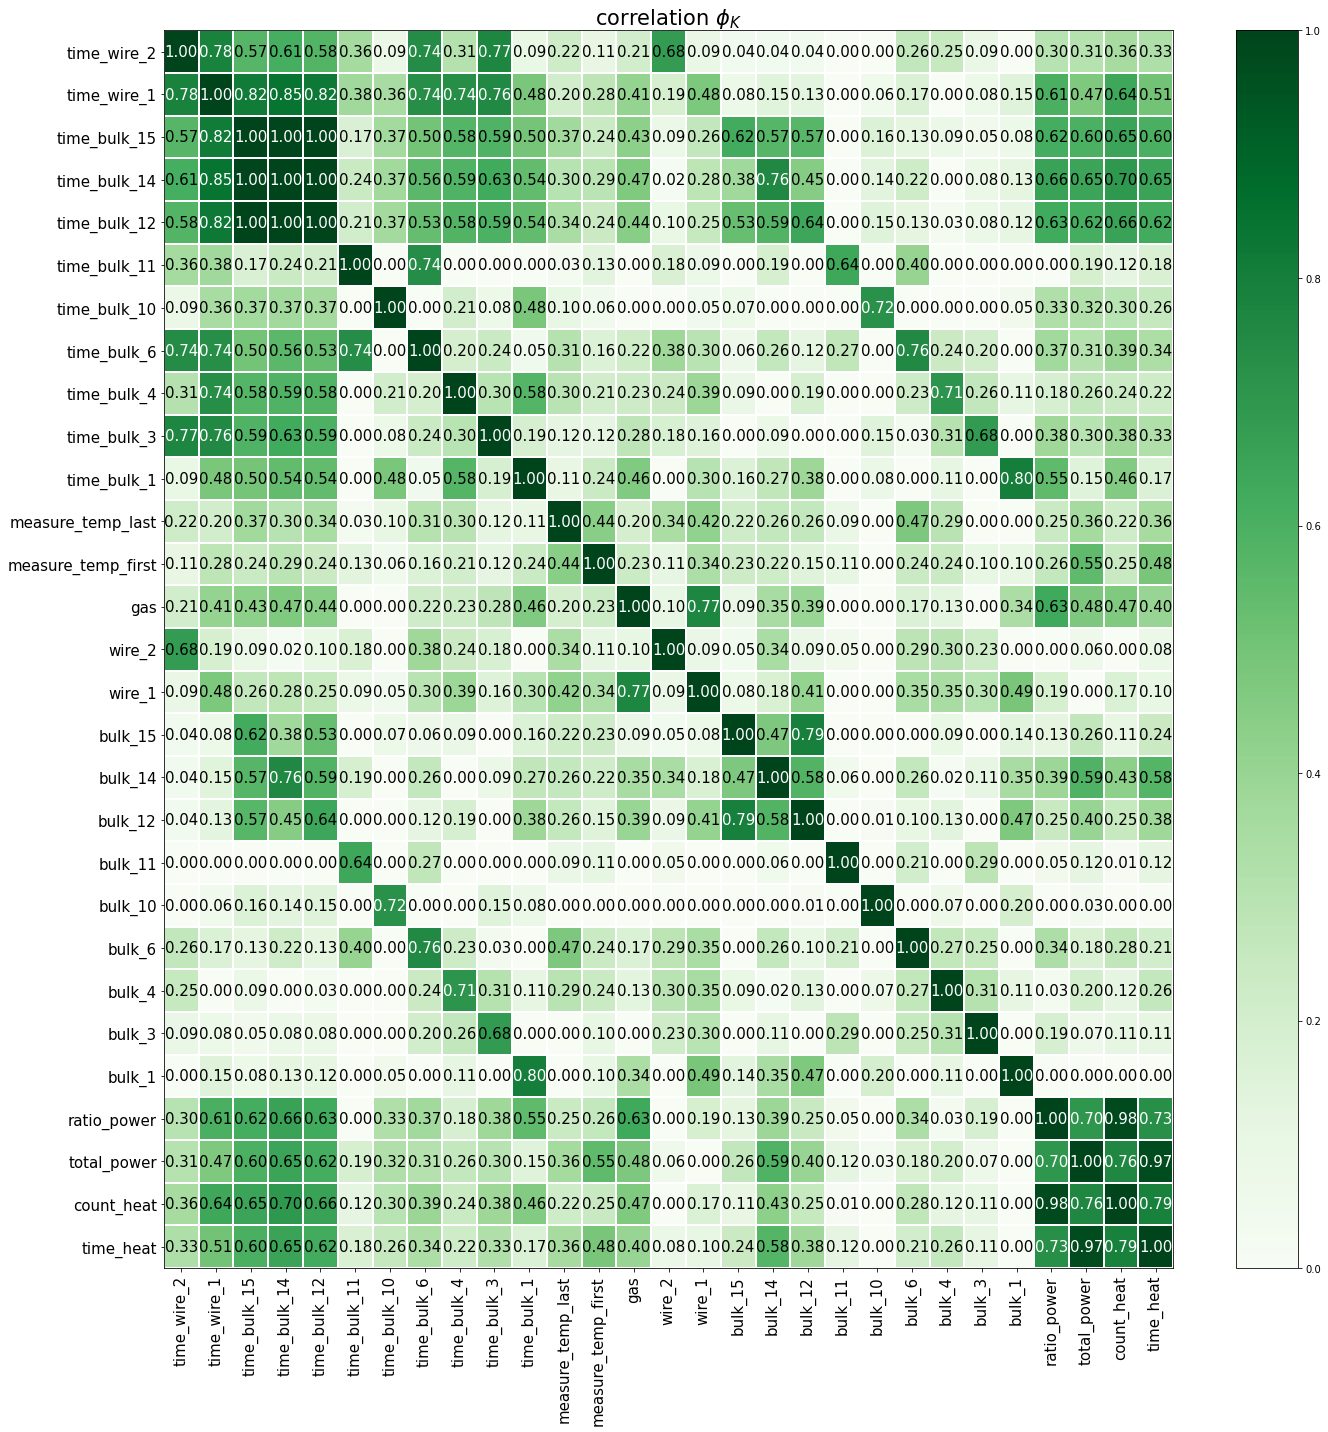

In [73]:
phic_matr = data.phik_matrix()
plot_correlation_matrix(phic_matr.values,
                        x_labels=phic_matr.columns,
                        y_labels=phic_matr.index,
                        vmin=0,
                        vmax=1,
                        color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(20, 20));
plt.tight_layout();

Высокая корреляция (больше 0.9) у признаков count_heat и ratio_power, у time_heat и total_power, у time_bulk_12, time_bulk_14 и time_bulk_15.

Построим матрицу корреляции для целевого признака.

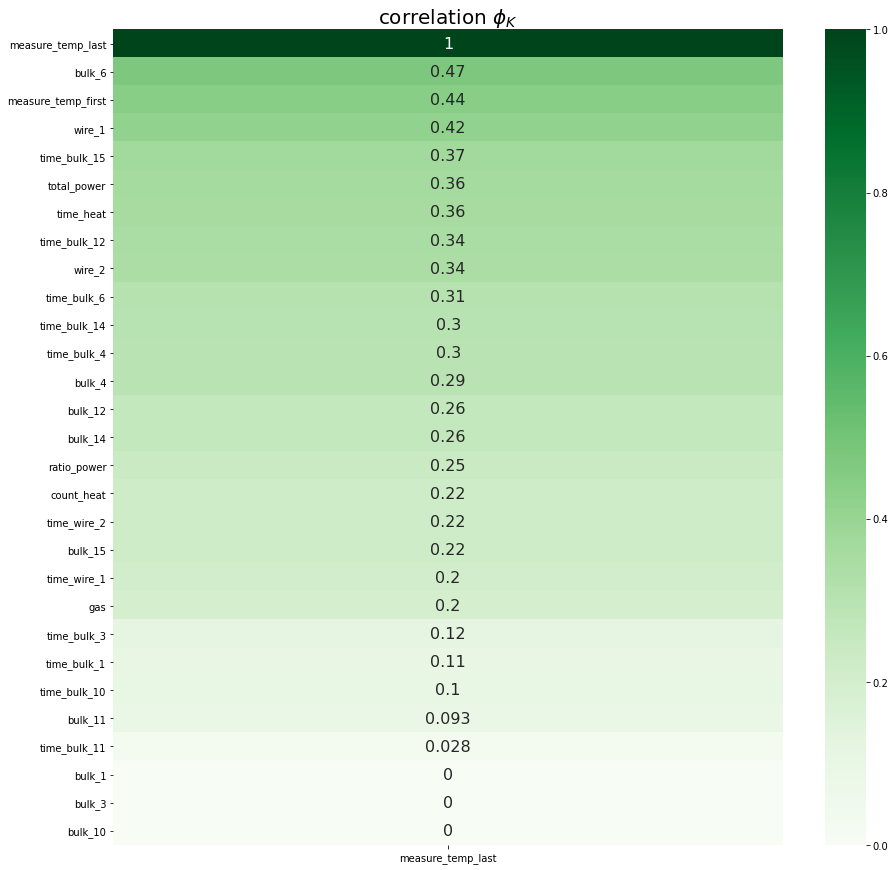

In [74]:
plt.figure(figsize=(15, 15));
sns.heatmap(phic_matr.sort_values(by = 'measure_temp_last', ascending=False)[['measure_temp_last']],
            cmap='Greens',
            annot=True,
            annot_kws={'size':16},
            fmt='.2g');
plt.title(r"correlation $\phi_K$", fontsize=20);
plt.show();

Больше всего с целевым признаком коррелирует bulk_6 и measure_temp_first.

Удалим признаки с сильной корреляцией - total_power, count_heat, time_bulk_12, time_bulk_14.

In [75]:
data = data.drop(['total_power', 'count_heat', 'time_bulk_12', 'time_bulk_14'], axis=1)

Построим графики зависимости от целевого признака - последнее измерение температуры, а также распределения всех признаков.

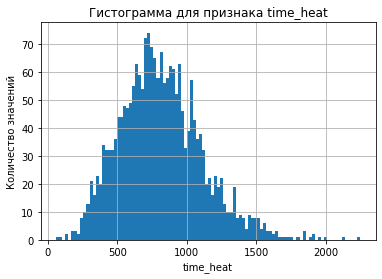

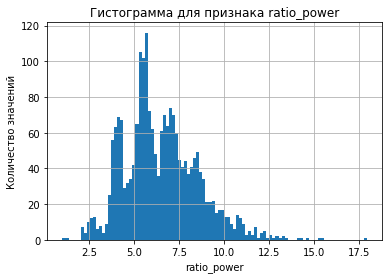

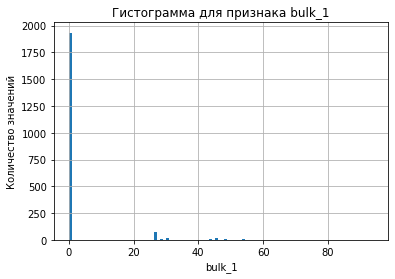

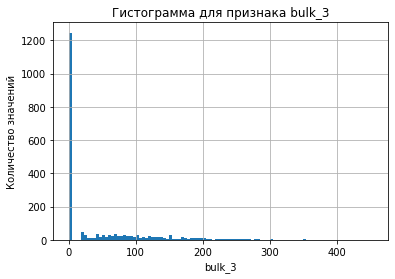

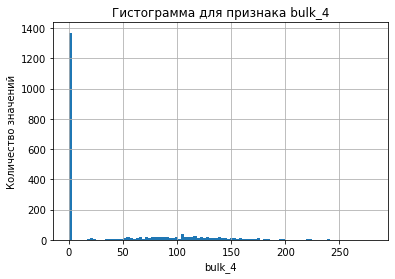

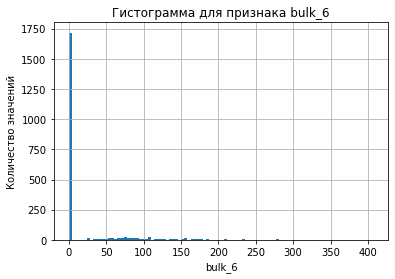

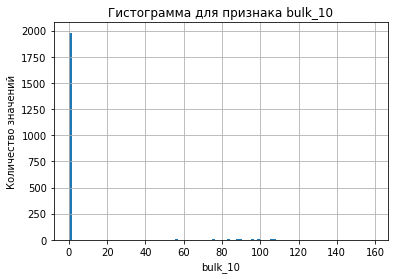

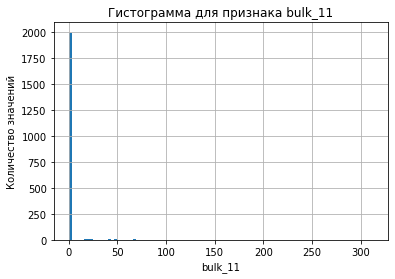

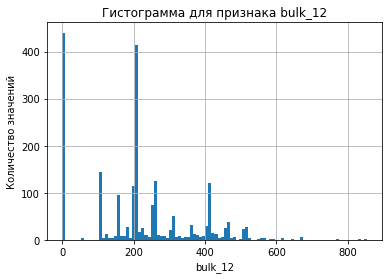

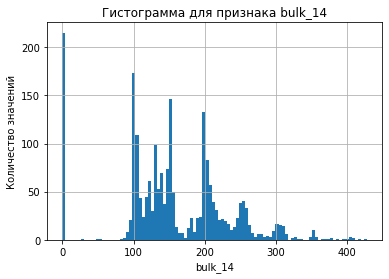

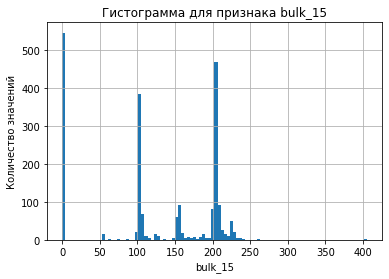

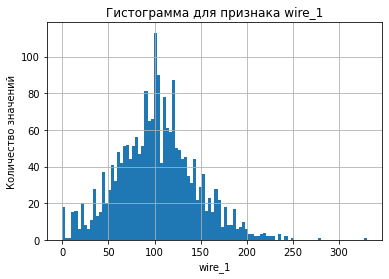

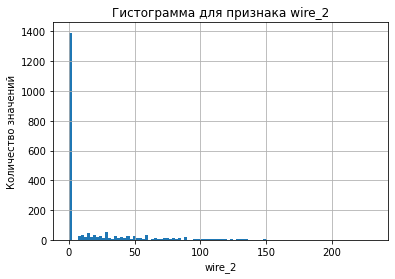

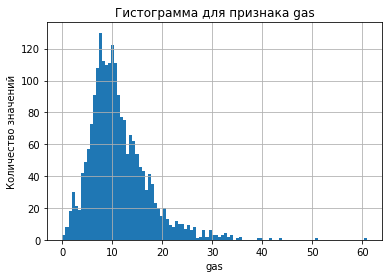

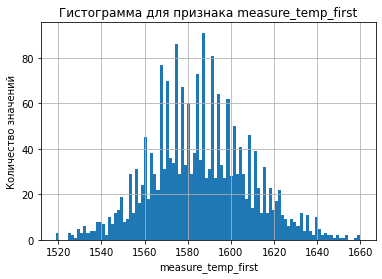

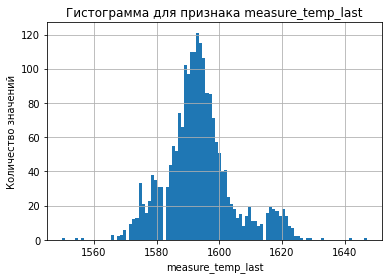

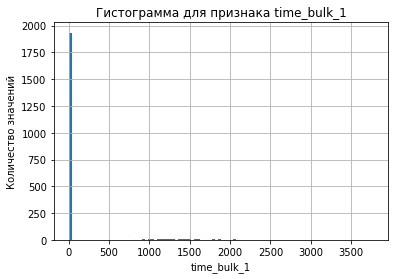

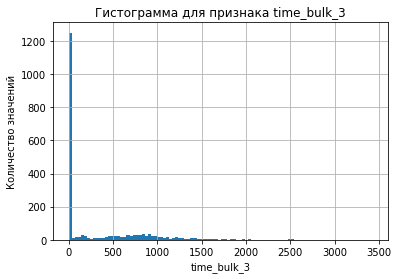

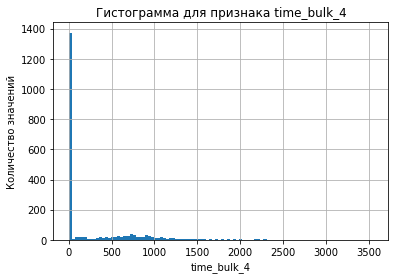

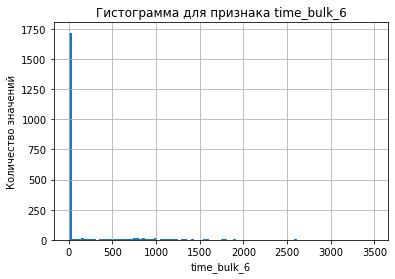

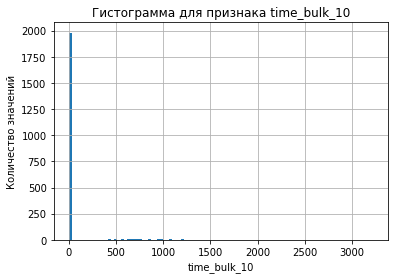

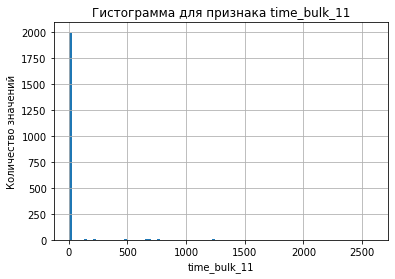

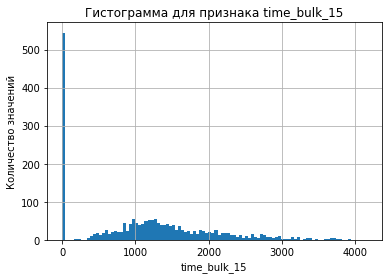

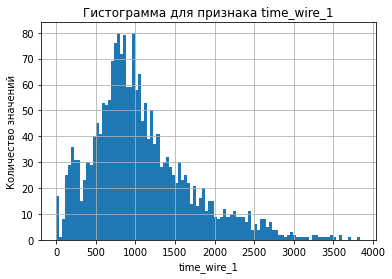

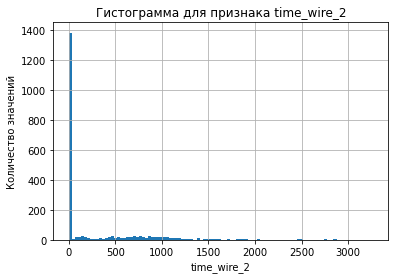

In [76]:
plot_func(data, True, False)

- Время нарева имеет распределение схожее с распределением Гаусса, чаще всего металл нагревали 600-700 секунд.
- Чаще всего соотношение активной и реактивной мощности равняется 5-6.
- Сыпучий материал №1, №3 и №11 добавляли редко, но если добавляли, то чаще всего около 20-25.
- Сыпучий материал №4, №6, №10 добавляли редко, но если добавляли, то чаще всего около 100-105. 
- Сыпучий материал №12, №14 и №15 добавляли чаще остальных, чаще всего объеме 100, 150, 200.
- Сыпучий материал №3, №4 чаще всего нагревался вместе с основным материалом около 800-900 секунд.
- Сыпучий материал №12, №14 и №15 чаще всего нагревался вместе с основным материалом около 1000-1200 секунд.
- Проволочный материал №1 добавляли чаще остальных, чаще всего в объеме 100, время нагрева с основным материалом чаще всего равняется 800-1000 секунд.
- Проволочный материал №2 добавляли редко, но если добавляли, то чаще всего около 20-25, время нагрева с основным материалом чаще всего равняется 800-1000 секунд.
- Объем подаваемого газа имеет распределение схожее с распределением Гаусса, чаще всего газ подавали в объеме 8-10.
- Начальная температура чаще всего равняется 1585-1590.
- Конечная температура имеет распределение схожее с распределением Гаусса, чаще всего металл нагревали до 1590-1595.
- Экстремальные выбросы не наблюдаются.

In [77]:
def scatter_plot_func(data, columns, xlabel):
    plt.figure(figsize=(10,10))
    legend_names = []
    for c in data.loc[:, columns].drop(['measure_temp_last'], axis=1).columns:
        sns.scatterplot(data=data.loc[:, columns], x=c, y='measure_temp_last', s=35);
        legend_names.append(data[c].name)
    plt.ylabel('temperature')
    plt.xlabel(xlabel)
    plt.title('Temperature dependence on the ' + xlabel)
    plt.grid()
    plt.legend(legend_names)
    plt.tight_layout()
    plt.show()

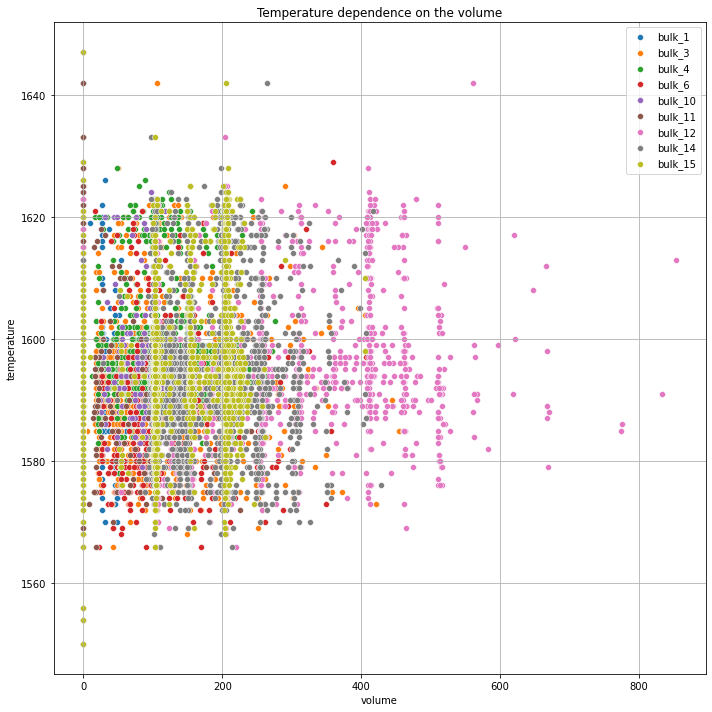

In [78]:
columns_bulk = ['measure_temp_last', 'bulk_1', 'bulk_3', 'bulk_4',
                'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15']

scatter_plot_func(data, columns_bulk, 'volume')

Зависимость между конечной температурой и объемом сыпучего материала не наблюдается. Материал bulk_12 подавался в самых больших объемах.

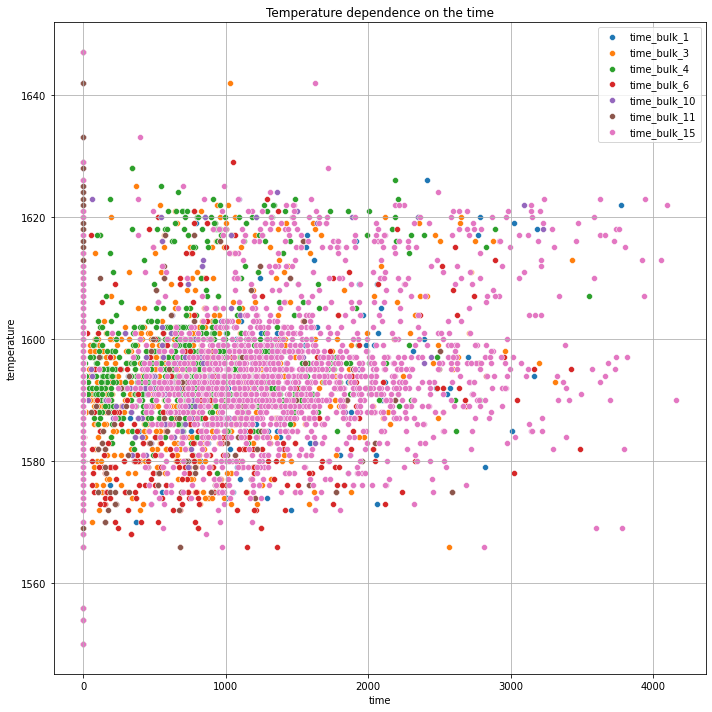

In [79]:
columns_bulk = ['measure_temp_last', 'time_bulk_1', 'time_bulk_3', 'time_bulk_4',
                'time_bulk_6', 'time_bulk_10', 'time_bulk_11', 'time_bulk_15']

scatter_plot_func(data, columns_bulk, 'time')

Зависимость между конечной температурой и времненем нагрева основного материала с добавлением сыпучего материала не наблюдается.

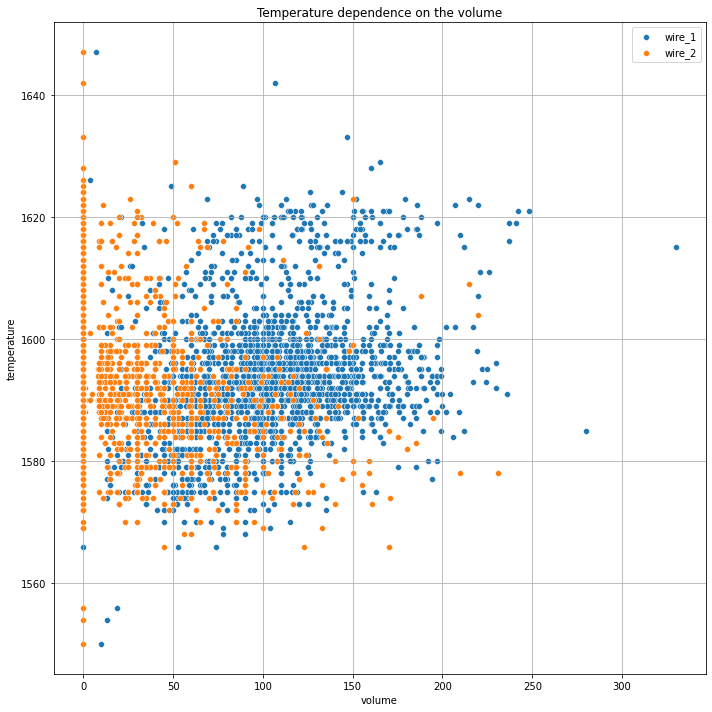

In [80]:
columns_wire = ['measure_temp_last', 'wire_1', 'wire_2']

scatter_plot_func(data, columns_wire, 'volume')

Зависимость между конечной температурой и объемом проволочного материала не наблюдается. Материал wire_1 подавался в самых больших объемах.

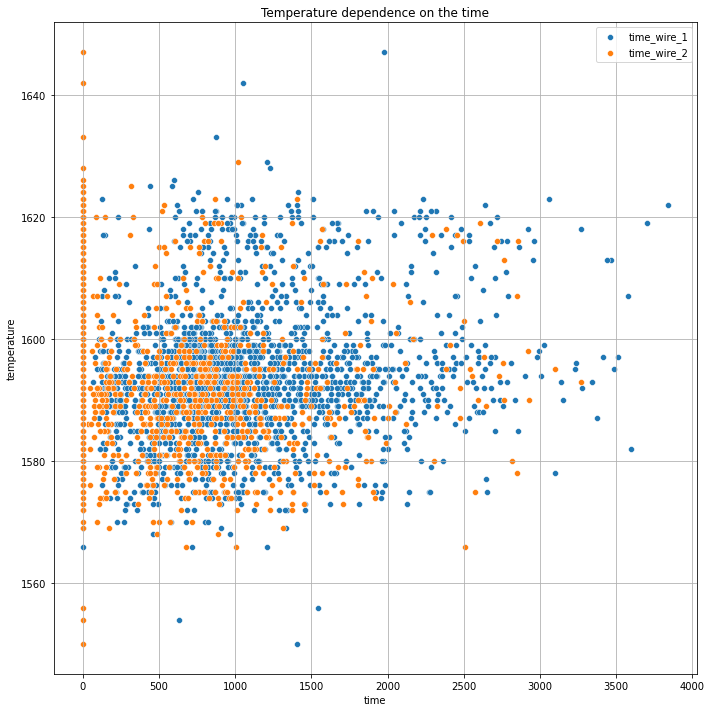

In [81]:
columns_wire = ['measure_temp_last', 'time_wire_1', 'time_wire_2']

scatter_plot_func(data, columns_wire, 'time')

Зависимость между конечной температурой и времненем нагрева основного материала с добавлением проволочного материала не наблюдается.

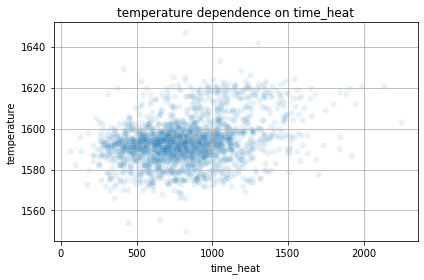

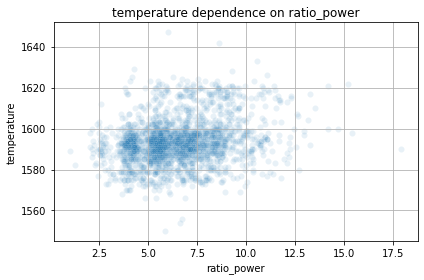

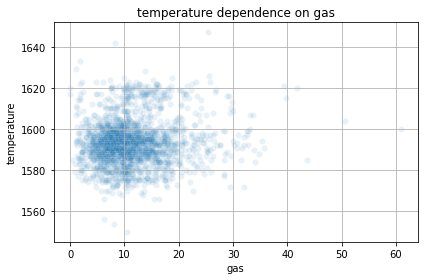

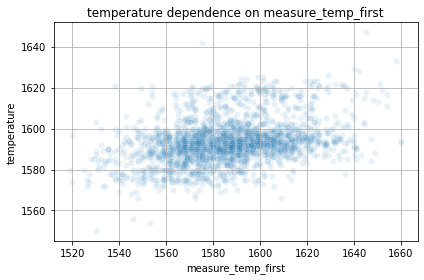

In [82]:
columns_another = ['measure_temp_last', 'time_heat', 'ratio_power', 'gas', 'measure_temp_first']

for c in data.loc[:, columns_another].drop(['measure_temp_last'], axis=1).columns:
    sns.scatterplot(data=data.loc[:, columns_another], x=c, y='measure_temp_last', alpha=0.1);
    plt.ylabel('temperature')
    plt.xlabel(c)
    plt.title('temperature dependence on ' + c)
    plt.grid()
    plt.tight_layout()
    plt.show()

- Зависимости между конечной температурой и временем нагрева не было найдено.
- Зависимости между конечной температурой и отношенением активной и реактивной мощностей не найдено.
- Зависимости между конечной температурой и объемом подаваемого газа не найдено.
- Зависимости между конечной температурой и начальной температурой не наблюдается.

**Вывод:**

**Были объединены таблицы data_arc, data_bulk, data_wire, data_gas, data_temp, data_bulk_time, data_wire_time по ключу - номер партии и получен итоговый датасет. Датасет имеет 2106 строк и 25 признаков, включая целевой.**

**Был произведен корреляционный анализ. Высокая корреляция (больше 0.9) у признаков count_heat и ratio_power, у time_heat и total_power, а также у time_bulk_12, time_bulk_14 и time_bulk_15. Больше всего с целевым признаком коррелирует bulk_6 и measure_temp_first. Были удалены признаки с сильной корреляцией - total_power, count_heat, time_bulk_12, time_bulk_14.**

**Были построены гистограммы и графики зависимости от целевого признака - последнее измерение температуры:**

- **Время нарева имеет распределение схожее с распределением Гаусса, чаще всего металл нагревали 600-700 секунд.**
- **Чаще всего соотношение активной и реактивной мощности равняется 5-6.**
- **Сыпучий материал №1, №3 и №11 добавляли редко, но если добавляли, то чаще всего около 20-25.**
- **Сыпучий материал №4, №6, №10 добавляли редко, но если добавляли, то чаще всего около 100-105.**
- **Сыпучий материал №12, №14 и №15 добавляли чаще остальных, чаще всего объеме 100, 150, 200.**
- **Сыпучий материал №3, №4 чаще всего нагревался вместе с основным материалом около 800-900 секунд.**
- **Сыпучий материал №12, №14 и №15 чаще всего нагревался вместе с основным материалом около 1000-1200 секунд.**
- **Проволочный материал №1 добавляли чаще остальных, чаще всего в объеме 100, время нагрева с основным материалом чаще всего - равняется 800-1000 секунд.**
- **Проволочный материал №2 добавляли редко, но если добавляли, то чаще всего около 20-25, время нагрева с основным материалом чаще всего равняется 800-1000 секунд.**
- **Объем подаваемого газа имеет распределение схожее с распределением Гаусса, чаще всего газ подавали в объеме 8-10.**
- **Начальная температура чаще всего равняется 1585-1590.**
- **Конечная температура имеет распределение схожее с распределением Гаусса, чаще всего металл нагревали до 1590-1595.**
- **Экстремальные выбросы не наблюдаются.**
- **зависимости от целевого признака не было найдено**


# Обучение

Разобьем датасет на обучающую и тестовую выборки.

In [83]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop(columns=['measure_temp_last'],axis=1),
    data['measure_temp_last'],
    test_size=0.25,
    shuffle=True,
    random_state=RANDOM_STATE)
print(features_train.shape)
print(features_test.shape)

(1579, 24)
(527, 24)


Отмасшатбируем данные с помощью StandardScaler.

In [84]:
scaler = StandardScaler().fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

## RandomForestRegressor

Получим значение метрики MAE на кросс-валидации на модели RandomForestRegressor с подбором гиперпараметров при помощи optuna.

In [85]:
def objective(trial, random_state=RANDOM_STATE):

    param = {}
    param['max_depth'] = trial.suggest_categorical('max_depth', [None] + [i for i in range(1,100,1)])
    param['max_features'] = trial.suggest_categorical('max_features', [None,'sqrt','log2'])
    param['min_samples_leaf'] = trial.suggest_int('min_samples_leaf', 1, 10)
    param['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 10)
    param['n_estimators'] = trial.suggest_int('n_estimators', 10, 500)
    param['random_state'] = RANDOM_STATE

    regressor = RandomForestRegressor(**param)

    score = cross_val_score(regressor, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')

    return np.abs(score.mean())

In [86]:
%%time
study_rfr = optuna.create_study(study_name='rfr', direction='minimize')
study_rfr.optimize(objective, n_trials=30)

print("\nBest Params : {}".format(study_rfr.best_params))
print("\nBest Accuracy : {}".format(study_rfr.best_value))

[I 2024-02-29 16:00:46,235] A new study created in memory with name: rfr
[I 2024-02-29 16:00:59,556] Trial 0 finished with value: 6.1421109399472 and parameters: {'max_depth': 82, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 381}. Best is trial 0 with value: 6.1421109399472.
[I 2024-02-29 16:01:03,895] Trial 1 finished with value: 6.378641127274273 and parameters: {'max_depth': 97, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 321}. Best is trial 0 with value: 6.1421109399472.
[I 2024-02-29 16:01:06,312] Trial 2 finished with value: 6.532176559070588 and parameters: {'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 234}. Best is trial 0 with value: 6.1421109399472.
[I 2024-02-29 16:01:21,814] Trial 3 finished with value: 6.103308161197141 and parameters: {'max_depth': 42, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimato


Best Params : {'max_depth': 84, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 441}

Best Accuracy : 6.050396587581466
CPU times: user 3min 56s, sys: 662 ms, total: 3min 57s
Wall time: 3min 58s


Метрика MAE на RandomForestRegressor после кросс-валидации равняется 6.05. Подобранные гиперпараметры: максимальная глубина деревьев - 84, число признаков для выбора расщепления - None, минимальное число объектов в листьях - 2, минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться - 10, число деревьев - 441.

## CatBoostRegressor

Получим значение метрики MAE на кросс-валидации на модели CatBoostRegressor с подбором гиперпараметров при помощи optuna.

In [87]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float('learning_rate', 0.001, 0.03, step=0.001)
    param['depth'] = trial.suggest_int('depth', 2, 6)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 7, step=0.5)
    param['random_state'] = RANDOM_STATE

    regressor = CatBoostRegressor(**param, verbose=False)

    score = cross_val_score(regressor, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')

    return np.abs(score.mean())

In [88]:
%%time
study_cbr = optuna.create_study(study_name='cbr', direction='minimize')
study_cbr.optimize(objective, n_trials=30)

print("\nBest Params : {}".format(study_cbr.best_params))
print("\nBest Accuracy : {}".format(study_cbr.best_value))

[I 2024-02-29 16:04:44,420] A new study created in memory with name: cbr
[I 2024-02-29 16:05:01,319] Trial 0 finished with value: 5.670839730721651 and parameters: {'learning_rate': 0.024, 'depth': 5, 'l2_leaf_reg': 6.5}. Best is trial 0 with value: 5.670839730721651.
[I 2024-02-29 16:05:14,109] Trial 1 finished with value: 5.71167637113451 and parameters: {'learning_rate': 0.013000000000000001, 'depth': 4, 'l2_leaf_reg': 3.0}. Best is trial 0 with value: 5.670839730721651.
[I 2024-02-29 16:05:31,547] Trial 2 finished with value: 6.130533255435218 and parameters: {'learning_rate': 0.004, 'depth': 5, 'l2_leaf_reg': 2.5}. Best is trial 0 with value: 5.670839730721651.
[I 2024-02-29 16:05:44,144] Trial 3 finished with value: 5.7167175597837 and parameters: {'learning_rate': 0.017, 'depth': 4, 'l2_leaf_reg': 6.0}. Best is trial 0 with value: 5.670839730721651.
[I 2024-02-29 16:06:08,037] Trial 4 finished with value: 5.704412205000341 and parameters: {'learning_rate': 0.019000000000000003, 


Best Params : {'learning_rate': 0.024, 'depth': 4, 'l2_leaf_reg': 4.0}

Best Accuracy : 5.645662736997371
CPU times: user 4min 48s, sys: 13.4 s, total: 5min 1s
Wall time: 6min 59s


Метрика MAE на CatBoostRegressor после кросс-валидации равняется 5.65. Подобранные гиперпараметры: learning_rate - 0.024, depth - 4, l2_leaf_reg - 4.0.

## Нейронная сеть

Получим значение метрики MAE на кросс-валидации при помощи полносвязной нейронной сети с 4 слоями с применением BatchNormalization.

In [89]:
def baseline_model():
    model = Sequential()
    model.add(Dense(8, input_dim=features_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    return model

In [90]:
%%time
kr = KerasRegressor(model=baseline_model,
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss=keras.losses.mean_squared_error,
                    batch_size=8,
                    epochs=200,
                    verbose=1,
                    random_state=RANDOM_STATE)
score = cross_val_score(kr, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print(np.abs(score.mean()))

2024-02-29 16:11:44.031217: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
158/158 [==============================] - 2s 4ms/step - loss: 2538372.0000
Epoch 2/200
158/158 [==============================] - 1s 3ms/step - loss: 2537077.5000
Epoch 3/200
158/158 [==============================] - 1s 4ms/step - loss: 2534924.2500
Epoch 4/200
158/158 [==============================] - 1s 3ms/step - loss: 2531954.0000
Epoch 5/200
158/158 [==============================] - 1s 4ms/step - loss: 2528224.5000
Epoch 6/200
158/158 [==============================] - 1s 4ms/step - loss: 2523777.7500
Epoch 7/200
158/158 [==============================] - 1s 3ms/step - loss: 2518657.2500
Epoch 8/200
158/158 [==============================] - 1s 4ms/step - loss: 2512899.7500
Epoch 9/200
158/158 [==============================] - 1s 3ms/step - loss: 2506543.0000
Epoch 10/200
158/158 [==============================] - 1s 3ms/step - loss: 2499615.7500
Epoch 11/200
158/158 [==============================] - 1s 3ms/step - loss: 2492140.2500
Epoch 12/200
158/158 [========

Метрика MAE на нейронной сети после кросс-валидации равняется 6.05.

**Вывод:**

**Данные были разбиты на обучающую и тестовую выборки. Данные были отмасштабированы с помощью StandardScaler.**

**Были рассмотрены следующие модели:**

- **RandomForestRegressor**
- **CatBoostRegressor**
- **Нейронная сеть**

**Были получены следующие результаты на тренировочном датасете:**

- **Метрика MAE на RandomForestRegressor после кросс-валидации равняется 6.05. Подобранные гиперпараметры: максимальная глубина деревьев - 84, число признаков для выбора расщепления - None, минимальное число объектов в листьях - 2, минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться - 10, число деревьев - 441.**
- **Метрика MAE на CatBoostRegressor после кросс-валидации равняется 5.65. Подобранные гиперпараметры: learning_rate - 0.024, depth - 4, l2_leaf_reg - 4.0.**
- **Метрика MAE на нейронной сети с 4 слоями с применением BatchNormalization после кросс-валидации равняется 6.05.**

**Наилучшая модель - CatBoostRegressor с гиперпараметрами learning_rate - 0.024, depth - 4, l2_leaf_reg - 4.0**

# Тестирование

Получим метрику MAE константной модели.

In [91]:
dummy = DummyRegressor(strategy='mean').fit(features_train, target_train)
predictions_dummy = dummy.predict(features_test)
mae = mean_absolute_error(target_test, predictions_dummy)
mae

7.805957701473199

Получим метрику MAE и R2 для тестовых данных для CatBoostRegressor с гиперпараметрами learning_rate - 0.024, depth - 4, l2_leaf_reg - 4.0.

In [92]:
cbr = CatBoostRegressor(**study_cbr.best_params, random_state=RANDOM_STATE, verbose=False)

cbr.fit(features_train, target_train)

predictions_cbr = cbr.predict(features_test)
print('MAE:', mean_absolute_error(target_test, predictions_cbr))
print('r2:', r2_score(target_test, predictions_cbr))

MAE: 5.904906194818461
r2: 0.4676319976742991


MAE равняется 5.90, что удовлетворяет условиям заказчика (ниже 6.8).

Результат метрики на лучшей модели ниже метрики на константной модели, что говорит об адекватности модели (ниже 7.81).

R2 равняется 0.47. Значение R2 ниже 0.5 означает, что модель не очень хорошо аппроксимирует данные, ее способность делать прогнозы не очень высокая.


Проведем анализ важности признаков наилучшей модели при помощи permutation_importance() и построим график важности признаков.

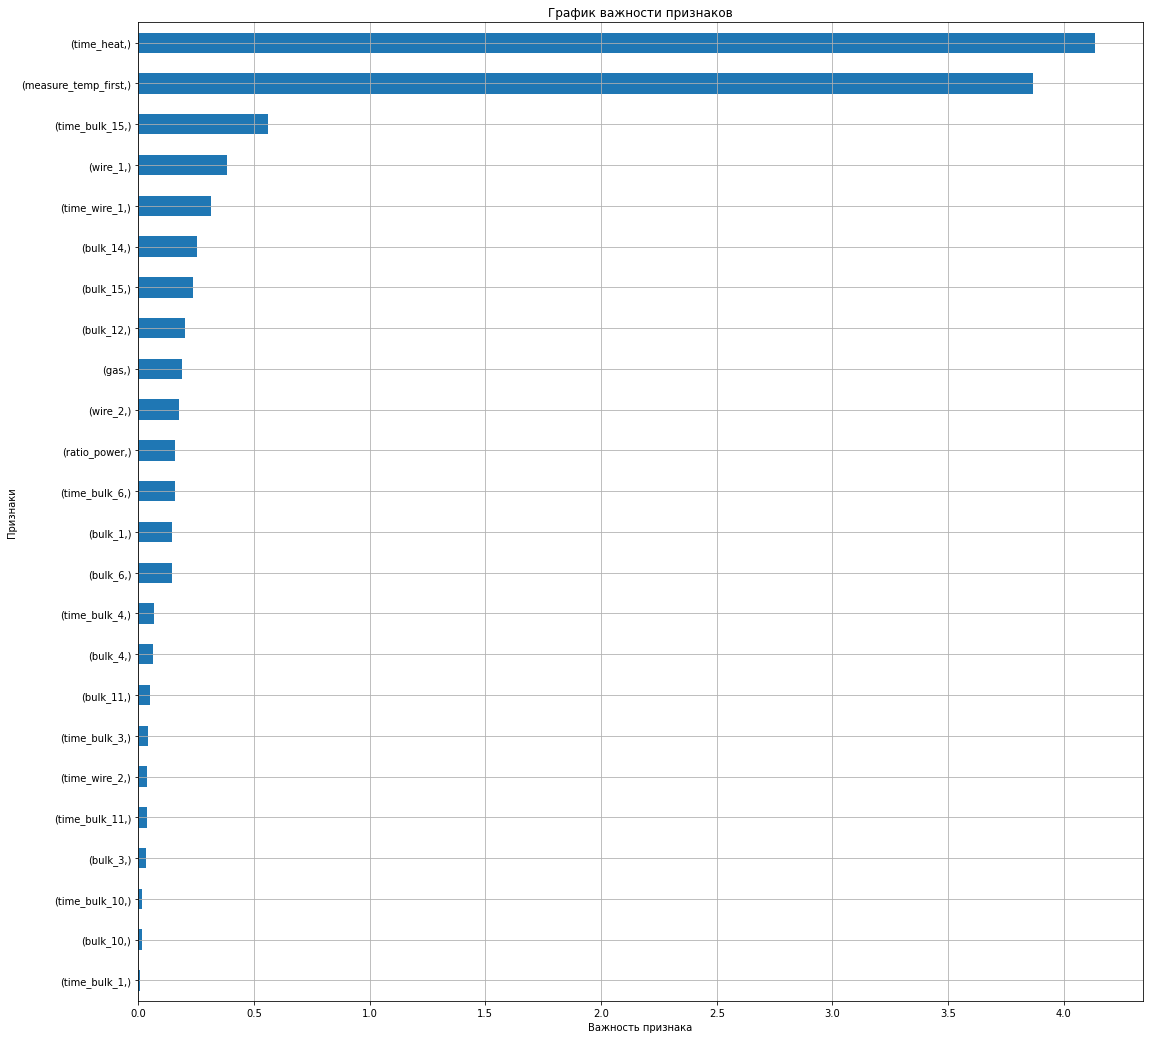

In [93]:
importance = permutation_importance(cbr, features_train, target_train, scoring='neg_mean_absolute_error')

_ = (pd.Series(importance.importances_mean, index=[data.drop(columns=['measure_temp_last'],axis=1).columns])
        .sort_values(ascending=True)
        .plot(kind="barh",
              figsize=(18,18),
              grid=True,
              title='График важности признаков'))
plt.xlabel('Важность признака');
plt.ylabel('Признаки');

Наиболее важные признаки для модели:

- время нагрева
- первоначальная температура
- время нагрева основного материала с сыпучим материалом №15
- объем проволочного материала №1
- время нагрева основного материала с проволочным материалом №1

Построии для одного из важных признаков для модели (первоначальная температура) график зависимости от целевого признака.

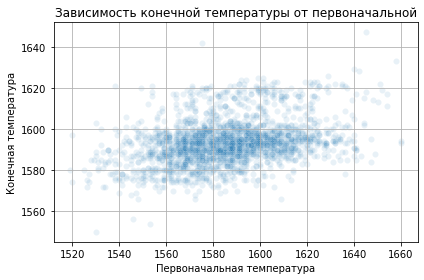

In [94]:
sns.scatterplot(data=data, x='measure_temp_first', y='measure_temp_last', alpha=0.1);
plt.ylabel('Конечная температура')
plt.xlabel('Первоначальная температура')
plt.title('Зависимость конечной температуры от первоначальной')
plt.grid()
plt.tight_layout()
plt.show()

Зависимости между конечной температурой и начальной температурой не наблюдается.

**Вывод:**

**MAE равняется 5.90, что удовлетворяет условиям заказчика (ниже 6.8).**

**Результат метрики на лучшей модели ниже метрики на константной модели, что говорит об адекватности модели (ниже 7.81).**

**R2 равняется 0.47. Значение R2 ниже 0.5 означает, что модель не очень хорошо аппроксимирует данные, ее способность делать прогнозы не очень высокая.**

**Был проведен анализ важности признаков.**

**Наиболее важные признаки для модели:**

- **время нагрева**
- **первоначальная температура**
- **время нагрева основного материала с сыпучим материалом №15**
- **объем проволочного материала №1**
- **время нагрева основного материала с проволочным материалом №1**

**Был построен график зависимости одного из важных признаков для модели (первоначальная температура) от конечной температуры. Зависимости между конечной температурой и начальной температурой не наблюдается.**

# Общий вывод

**Описание**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Моя задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Исследовательский анализ и предобработка данных**

После предобработки был получен датасет, состоящий из 2106 строк и 25 признаков (время нагрева, соотношение активной и реактивной мощности, объем сыпучего материала, объем провочного материала, объем газа, начальная температура, последняя температура, время нагрева основного материала с добавлением сыпучего, время нагрева основного материала с добавлением проволочного). Датасет был сформирован из таблиц, выгруженных из базы данных (data_arc, data_bulk, data_wire, data_gas, data_temp, data_bulk_time, data_wire_time). Данные были предварительно предобработаны: удалены аномальные значения(отрицательная мощность, температура ниже 1500, некорректное время нагрева с добалением сыпучего или провлочного материала), заменены пропуски (в столбцах объема и времени добавления сыпучего и проволочного материала заменены на 0, так как пропуски означали то, что материал не добавляли), дубликатов и выбросов обнаружено не было, были сформированы новые признаки (время нагрева, количество запусков нагрева, общая мощность, соотношение активной и реактивной мощности). Были удалены малоинформативные столбцы в таблицах с объемом проволочного и сыпучего материала.

Датасет был исследован:

1. Был произведен корреляционный анализ. Высокая корреляция (больше 0.9) у признаков count_heat и ratio_power, у time_heat и total_power, а также у time_bulk_12, time_bulk_14 и time_bulk_15. Больше всего с целевым признаком коррелирует bulk_6 и measure_temp_first. Были удалены признаки с сильной корреляцией - total_power, count_heat, time_bulk_12, time_bulk_14.

2. Были построены графики всех распределений признаков и зависимости признаков от целевого признака.

- Распределение времени нагрева, распределение количества запусков нагрева, распределение общей мощности, распределение соотношения активной и реактивной мощности похожи на распределение Гаусса с хвостом в правой части.
- Время нарева имеет распределение схожее с распределением Гаусса, чаще всего металл нагревали 600-700 секунд.
- Чаще всего соотношение активной и реактивной мощности равняется 5-6.
- Сыпучий материал №1, №3 и №11 добавляли редко, но если добавляли, то чаще всего около 20-25.
- Сыпучий материал №4, №6, №10 добавляли редко, но если добавляли, то чаще всего около 100-105. 
- Сыпучий материал №12, №14 и №15 добавляли чаще остальных, чаще всего объеме 100, 150, 200.
- Сыпучий материал №3, №4 чаще всего нагревался вместе с основным материалом около 800-900 секунд.
- Сыпучий материал №12, №14 и №15 чаще всего нагревался вместе с основным материалом около 1000-1200 секунд.
- Проволочный материал №1 добавляли чаще остальных, чаще всего в объеме 100, время нагрева с основным материалом чаще всего равняется 800-1000 секунд.
- Проволочный материал №2 добавляли редко, но если добавляли, то чаще всего около 20-25, время нагрева с основным материалом чаще всего равняется 800-1000 секунд.
- Объем подаваемого газа имеет распределение схожее с распределением Гаусса, чаще всего газ подавали в объеме 8-10.
- Начальная температура чаще всего равняется 1585-1590.
- Конечная температура имеет распределение схожее с распределением Гаусса, чаще всего металл нагревали до 1590-1595.

3. Был изучен процесс обработки для нескольких партий:

- Процесс обработки для первой партии включает в себя 5 итераций нагрева электродами, 4 итерации легирования различными сыпучими материалами, однократное легирование проволочными материалами. Первое измерение температуры происходит после 3 итераций нагрева электродами, последнее измерение температуры происходит после последнего нагрева электродами.
- Процесс обработки для 100 партии включает в себя 6 итераций нагрева электродами, 4 итерации легирования различными сыпучими материалами, однократное легирование проволочными материалами. Первое измерение температуры происходит после 1 итерации нагрева электродами, последнее измерение температуры происходит после последнего нагрева электродами.
- Процесс обработки для 1000 партии включает в себя 5 итераций нагрева электродами, однократное легирование различными сыпучими материалами, 2 итерации легирования проволочными материалами. Первое измерение температуры происходит после 1 итерации нагрева электродами, последнее измерение температуры происходит после последнего нагрева электродами.


**Обучение**

Данные были разбиты на обучающую и тестовую выборки. Данные были отмасштабированы с помощью StandardScaler.

Были рассмотрены следующие модели:

- RandomForestRegressor
- CatBoostRegressor
- Нейронная сеть

Были получены следующие результаты на тренировочном датасете:

- Метрика MAE на RandomForestRegressor после кросс-валидации равняется 6.05. Подобранные гиперпараметры: максимальная глубина деревьев - 84, число признаков для выбора расщепления - None, минимальное число объектов в листьях - 2, минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться - 10, число деревьев - 441.
- Метрика MAE на CatBoostRegressor после кросс-валидации равняется 5.65. Подобранные гиперпараметры: learning_rate - 0.024, depth - 4, l2_leaf_reg - 4.0.
- Метрика MAE на нейронной сети с 4 слоями с применением BatchNormalization после кросс-валидации равняется 6.05.

Наилучшая модель - CatBoostRegressor с гиперпараметрами learning_rate - 0.024, depth - 4, l2_leaf_reg - 4.0


**Тестирование**

MAE равняется 5.90, что удовлетворяет условиям заказчика (ниже 6.8).

Результат метрики на лучшей модели ниже метрики на константной модели, что говорит об адекватности модели (ниже 7.81).

R2 равняется 0.47. Значение R2 ниже 0.5 означает, что модель не очень хорошо аппроксимирует данные, ее способность делать прогнозы не очень высокая.

Был проведен анализ важности признаков.

Наиболее важные признаки для модели:

- время нагрева
- первоначальная температура
- время нагрева основного материала с сыпучим материалом №15
- объем проволочного материала №1
- время нагрева основного материала с проволочным материалом №1

Был построен график зависимости одного из важных признаков для модели (первоначальная температура) от конечной температуры. Зависимости между конечной температурой и начальной температурой не наблюдается.

**Рекомендации заказчику**

1. Для имитации технологического процесса лучше всего подойдет CatBoostRegressor. Метрика MAE для этой модели на тренировочной выборке равняется 5.65, а на тестовой - 5.90.
2. Необходимо использовать выборку большего размера для получения адекватной модели.
3. Необходимо регламентировать замеры температуры, так как измерения первоначальной температуры на данный момент могли происходить не после первого нагрева электродами, а измерение последней температуры могло происходить не сразу после окончания нагрева электродами.
4. Рекомендуется синхронизировать датчики времени, так как это может позволить избежать потери данных.